#Setup

In [ ]:
"""
BERT-based Phishing Email Detection with Cross-Dataset Evaluation
For use in Google Colab
"""

# ============================================================================
# SECTION 1: SETUP AND INSTALLATION
# ============================================================================

# Install required packages (suppress output)
import sys
import subprocess

print("Installing packages... (this may take a minute)")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                      "transformers", "datasets", "scikit-learn",
                      "pandas", "matplotlib", "seaborn", "torch"])
print("✓ Installation complete!")

# Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW  # ← FIXED: Import from torch.optim instead
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

# ============================================================================
# SECTION 2: MOUNT GOOGLE DRIVE AND LOAD DATA
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

# File paths - ADJUST THESE TO YOUR GOOGLE DRIVE PATHS
DATASET1_PATH = "/content/drive/MyDrive/CleanedProjectDatasets/Dataset1.csv"
DATASET2_PATH = "/content/drive/MyDrive/CleanedProjectDatasets/Dataset2.csv"
DATASET3_PATH = "/content/drive/MyDrive/CleanedProjectDatasets/Dataset3.csv"

# Load datasets
print("\nLoading datasets...")
df1 = pd.read_csv(DATASET1_PATH)
df2 = pd.read_csv(DATASET2_PATH)
df3 = pd.read_csv(DATASET3_PATH)

# Display basic information
print("\n=== Dataset Information ===")
print(f"Dataset 1: {len(df1)} samples")
print(f"  - Phishing: {sum(df1['label'] == 1)}")
print(f"  - Legitimate: {sum(df1['label'] == 0)}")

print(f"\nDataset 2: {len(df2)} samples")
print(f"  - Phishing: {sum(df2['label'] == 1)}")
print(f"  - Legitimate: {sum(df2['label'] == 0)}")

print(f"\nDataset 3: {len(df3)} samples")
print(f"  - Phishing: {sum(df3['label'] == 1)}")
print(f"  - Legitimate: {sum(df3['label'] == 0)}")

# ============================================================================
# SECTION 3: DATA PREPROCESSING
# ============================================================================

def clean_text(text):
    """Basic text cleaning"""
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Clean email text in all datasets
print("\nCleaning text...")
df1['email_text'] = df1['email_text'].apply(clean_text)
df2['email_text'] = df2['email_text'].apply(clean_text)
df3['email_text'] = df3['email_text'].apply(clean_text)

# Remove any rows with empty text
df1 = df1[df1['email_text'].str.len() > 0].reset_index(drop=True)
df2 = df2[df2['email_text'].str.len() > 0].reset_index(drop=True)
df3 = df3[df3['email_text'].str.len() > 0].reset_index(drop=True)

print("✓ Text cleaning complete.")

Installing packages... (this may take a minute)
✓ Installation complete!

✓ Using device: cuda
✓ GPU: Tesla T4
Mounted at /content/drive

Loading datasets...

=== Dataset Information ===
Dataset 1: 4000 samples
  - Phishing: 2000
  - Legitimate: 2000

Dataset 2: 10000 samples
  - Phishing: 6000
  - Legitimate: 4000

Dataset 3: 38164 samples
  - Phishing: 20856
  - Legitimate: 17308

Cleaning text...
✓ Text cleaning complete.


#Creating Functions


In [ ]:
# ============================================================================
# SECTION 4: CUSTOM DATASET CLASS FOR BERT
# ============================================================================

class PhishingEmailDataset(Dataset):
    """Custom Dataset for BERT tokenization"""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ============================================================================
# SECTION 5: MODEL TRAINING FUNCTION
# ============================================================================

def train_bert_model(train_df, val_df, model_name='bert-base-uncased',
                     epochs=3, batch_size=16, learning_rate=2e-5,
                     max_length=512):
    """
    Train BERT model on phishing email dataset

    Args:
        train_df: Training dataframe with 'email_text' and 'label'
        val_df: Validation dataframe
        model_name: Pre-trained BERT model name
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate
        max_length: Maximum sequence length

    Returns:
        Trained model, tokenizer
    """

    print(f"\n{'='*60}")
    print(f"Training BERT Model")
    print(f"{'='*60}")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")

    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    model.to(device)

    # Create datasets
    train_dataset = PhishingEmailDataset(
        train_df['email_text'].values,
        train_df['label'].values,
        tokenizer,
        max_length
    )

    val_dataset = PhishingEmailDataset(
        val_df['email_text'].values,
        val_df['label'].values,
        tokenizer,
        max_length
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        total_train_loss = 0

        progress_bar = tqdm(train_loader, desc='Training')
        for batch in progress_bar:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print("  → Best model so far!")

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, tokenizer

# ============================================================================
# SECTION 6: EVALUATION FUNCTION
# ============================================================================

def evaluate_model(model, tokenizer, test_df, batch_size=16, max_length=512):
    """
    Evaluate BERT model on test dataset

    Args:
        model: Trained BERT model
        tokenizer: BERT tokenizer
        test_df: Test dataframe with 'email_text' and 'label'
        batch_size: Batch size for evaluation
        max_length: Maximum sequence length

    Returns:
        Dictionary with performance metrics
    """

    model.eval()

    # Create dataset and dataloader
    test_dataset = PhishingEmailDataset(
        test_df['email_text'].values,
        test_df['label'].values,
        tokenizer,
        max_length
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Collect predictions
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['Legitimate', 'Phishing']))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }

# ============================================================================
# SECTION 7: CROSS-DATASET EXPERIMENT FUNCTION
# ============================================================================

def run_cross_dataset_experiment(datasets_dict, epochs=3, batch_size=16):
    """
    Run complete cross-dataset experiment

    Args:
        datasets_dict: Dictionary with dataset names as keys and dataframes as values
        epochs: Number of training epochs
        batch_size: Batch size

    Returns:
        Results dictionary with all metrics
    """

    results = {}
    dataset_names = list(datasets_dict.keys())

    for train_name in dataset_names:
        print(f"\n{'='*70}")
        print(f"TRAINING ON: {train_name}")
        print(f"{'='*70}")

        # Get training dataset
        train_full = datasets_dict[train_name]

        # Split into train/val (80/20)
        train_df, val_df = train_test_split(
            train_full,
            test_size=0.2,
            random_state=42,
            stratify=train_full['label']
        )

        # Train model
        model, tokenizer = train_bert_model(
            train_df,
            val_df,
            epochs=epochs,
            batch_size=batch_size
        )

        # Test on all datasets
        for test_name in dataset_names:
            print(f"\n--- Testing on: {test_name} ---")

            test_df = datasets_dict[test_name]

            # If testing on same dataset, use only the test split
            if test_name == train_name:
                _, test_df = train_test_split(
                    test_df,
                    test_size=0.2,
                    random_state=42,
                    stratify=test_df['label']
                )

            metrics = evaluate_model(model, tokenizer, test_df, batch_size=batch_size)

            # Store results
            key = f"{train_name} → {test_name}"
            results[key] = metrics

            print(f"\nResults for {key}:")
            print(f"  Accuracy:  {metrics['accuracy']:.4f}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall:    {metrics['recall']:.4f}")
            print(f"  F1 Score:  {metrics['f1']:.4f}")

    return results

# ============================================================================
# SECTION 8: VISUALIZATION FUNCTIONS
# ============================================================================

def plot_cross_dataset_results(results):
    """Create heatmap of cross-dataset performance"""

    # Extract dataset names
    dataset_names = sorted(list(set([k.split(' → ')[0] for k in results.keys()])))

    # Create matrices for each metric
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        matrix = np.zeros((len(dataset_names), len(dataset_names)))

        for i, train_ds in enumerate(dataset_names):
            for j, test_ds in enumerate(dataset_names):
                key = f"{train_ds} → {test_ds}"
                if key in results:
                    matrix[i, j] = results[key][metric]

        sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn',
                   xticklabels=dataset_names, yticklabels=dataset_names,
                   vmin=0, vmax=1, ax=axes[idx], cbar_kws={'label': metric.capitalize()})
        axes[idx].set_title(f'{metric.capitalize()} - Cross-Dataset Performance')
        axes[idx].set_xlabel('Test Dataset')
        axes[idx].set_ylabel('Train Dataset')

    plt.tight_layout()
    plt.savefig('cross_dataset_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_results_table(results):
    """Create a pandas DataFrame with all results"""

    rows = []
    for key, metrics in results.items():
        train_ds, test_ds = key.split(' → ')
        rows.append({
            'Train Dataset': train_ds,
            'Test Dataset': test_ds,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1 Score': f"{metrics['f1']:.4f}"
        })

    df_results = pd.DataFrame(rows)
    return df_results

# ============================================================================
# SECTION 9: SAVE/LOAD FUNCTIONS
# ============================================================================

import pickle
import os
from datetime import datetime

# Create directories for saving
MODEL_DIR = '/content/drive/MyDrive/CleanedProjectDatasets/phishing_models'
RESULTS_DIR = '/content/drive/MyDrive/CleanedProjectDatasets/phishing_results'

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

def save_model(model, tokenizer, dataset_name):
    """Save trained model and tokenizer to Google Drive"""
    save_path = f"{MODEL_DIR}/{dataset_name}_bert"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"✓ Model saved to: {save_path}")

def load_model(dataset_name):
    """Load trained model and tokenizer from Google Drive"""
    load_path = f"{MODEL_DIR}/{dataset_name}_bert"
    if os.path.exists(load_path):
        model = BertForSequenceClassification.from_pretrained(load_path)
        tokenizer = BertTokenizer.from_pretrained(load_path)
        model.to(device)
        print(f"✓ Model loaded from: {load_path}")
        return model, tokenizer
    else:
        print(f"✗ Model not found at: {load_path}")
        return None, None

def save_results(results, filename='results.pkl'):
    """Save results dictionary to Google Drive"""
    save_path = f"{RESULTS_DIR}/{filename}"
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)
    print(f"✓ Results saved to: {save_path}")

def load_results(filename='results.pkl'):
    """Load results dictionary from Google Drive"""
    load_path = f"{RESULTS_DIR}/{filename}"
    if os.path.exists(load_path):
        with open(load_path, 'rb') as f:
            results = pickle.load(f)
        print(f"✓ Results loaded from: {load_path}")
        return results
    else:
        print(f"✗ Results not found at: {load_path}")
        return {}

def save_experiment_state(train_name, completed_tests, results):
    """Save experiment state for resuming"""
    state = {
        'train_name': train_name,
        'completed_tests': completed_tests,
        'results': results,
        'timestamp': datetime.now().isoformat()
    }
    save_path = f"{RESULTS_DIR}/experiment_state_{train_name}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(state, f)
    print(f"✓ State saved: {train_name}")

def load_experiment_state(train_name):
    """Load experiment state for resuming"""
    load_path = f"{RESULTS_DIR}/experiment_state_{train_name}.pkl"
    if os.path.exists(load_path):
        with open(load_path, 'rb') as f:
            state = pickle.load(f)
        print(f"✓ State loaded for: {train_name}")
        return state
    return None

# ============================================================================
# SECTION 10: INDIVIDUAL EXPERIMENT RUNNER (RESUMABLE)
# ============================================================================

def run_single_training(train_name, train_df, val_df, epochs=3, batch_size=16, force_retrain=False):
    """
    Train model for a single dataset (with option to skip if already trained)

    Args:
        train_name: Name of training dataset
        train_df: Training dataframe
        val_df: Validation dataframe
        epochs: Number of epochs
        batch_size: Batch size
        force_retrain: If True, retrain even if model exists

    Returns:
        model, tokenizer
    """

    # Check if model already exists
    if not force_retrain:
        model, tokenizer = load_model(train_name)
        if model is not None:
            print(f"✓ Using existing model for {train_name}")
            return model, tokenizer

    # Train new model
    print(f"\n{'='*70}")
    print(f"TRAINING NEW MODEL: {train_name}")
    print(f"{'='*70}")

    model, tokenizer = train_bert_model(
        train_df,
        val_df,
        epochs=epochs,
        batch_size=batch_size
    )

    # Save the model
    save_model(model, tokenizer, train_name)

    return model, tokenizer

def run_single_experiment(train_name, test_name, datasets_dict,
                         epochs=3, batch_size=16, force_retrain=False):
    """
    Run a single train→test experiment

    Args:
        train_name: Dataset to train on
        test_name: Dataset to test on
        datasets_dict: Dictionary of all datasets
        epochs: Training epochs
        batch_size: Batch size
        force_retrain: Force retraining even if model exists

    Returns:
        metrics dictionary
    """

    experiment_key = f"{train_name} → {test_name}"
    print(f"\n{'='*70}")
    print(f"EXPERIMENT: {experiment_key}")
    print(f"{'='*70}")

    # Get training dataset and split
    train_full = datasets_dict[train_name]
    train_df, val_df = train_test_split(
        train_full,
        test_size=0.2,
        random_state=42,
        stratify=train_full['label']
    )

    # Train or load model
    model, tokenizer = run_single_training(
        train_name,
        train_df,
        val_df,
        epochs,
        batch_size,
        force_retrain
    )

    # Prepare test dataset
    test_df = datasets_dict[test_name]
    if test_name == train_name:
        # Use held-out test set
        _, test_df = train_test_split(
            test_df,
            test_size=0.2,
            random_state=42,
            stratify=test_df['label']
        )

    # Evaluate
    print(f"\n--- Testing on: {test_name} ---")
    metrics = evaluate_model(model, tokenizer, test_df, batch_size=batch_size)

    print(f"\nResults for {experiment_key}:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")

    return metrics

# ============================================================================
# SECTION 11: MAIN EXECUTION (MODULAR & RESUMABLE)
# ============================================================================

# Prepare datasets dictionary
datasets = {
    'Dataset1': df1,
    'Dataset2': df2,
    'Dataset3': df3
}

# PARAMETERS
EPOCHS = 3
BATCH_SIZE = 16
FORCE_RETRAIN = False  # Set to True to retrain existing models

# Initialize or load existing results
results = load_results('bert_cross_dataset_results.pkl')

print("\n" + "="*70)
print("CROSS-DATASET BERT EXPERIMENT (MODULAR)")
print("="*70)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Force Retrain: {FORCE_RETRAIN}")
print(f"Existing results: {len(results)} experiments")
print("="*70)



✓ Results loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

CROSS-DATASET BERT EXPERIMENT (MODULAR)
Epochs: 3
Batch Size: 16
Force Retrain: False
Existing results: 9 experiments



EXPERIMENT: Dataset1 → Dataset1
✗ Model not found at: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert

TRAINING NEW MODEL: Dataset1

Training BERT Model
Training samples: 3198
Validation samples: 800


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


  Train Loss: 0.1160
  Val Loss: 0.0244
  → Best model so far!

Epoch 2/3


Validation: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


  Train Loss: 0.0067
  Val Loss: 0.0101
  → Best model so far!

Epoch 3/3


Validation: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]

  Train Loss: 0.0005
  Val Loss: 0.0195


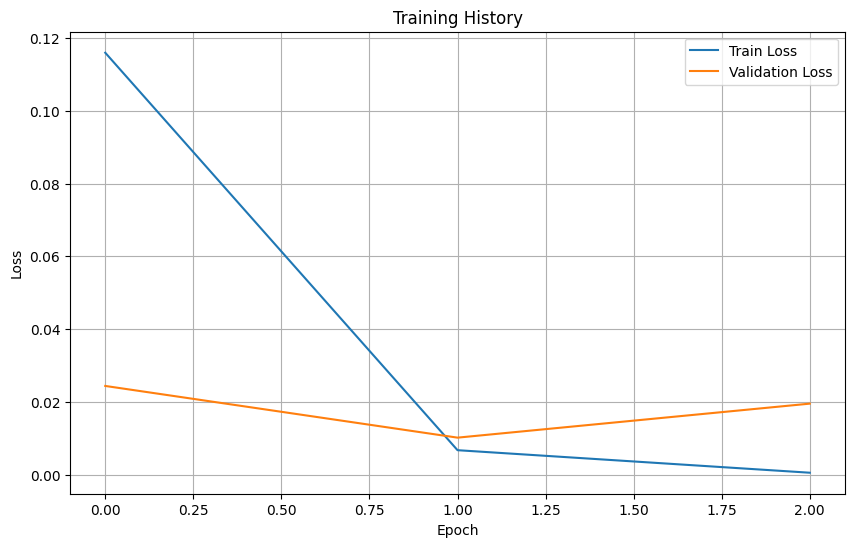

✓ Model saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert

--- Testing on: Dataset1 ---


Evaluating: 100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      1.00      1.00       400
    Phishing       1.00      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800



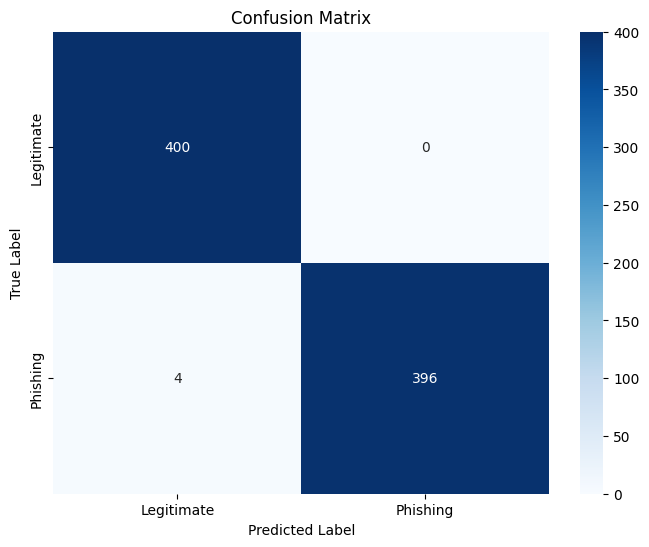


Results for Dataset1 → Dataset1:
  Accuracy:  0.9950
  Precision: 1.0000
  Recall:    0.9900
  F1 Score:  0.9950
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset1 → Dataset2
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert
✓ Using existing model for Dataset1

--- Testing on: Dataset2 ---


Evaluating: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.76      1.00      0.86      4000
    Phishing       1.00      0.79      0.88      6000

    accuracy                           0.88     10000
   macro avg       0.88      0.90      0.87     10000
weighted avg       0.90      0.88      0.88     10000



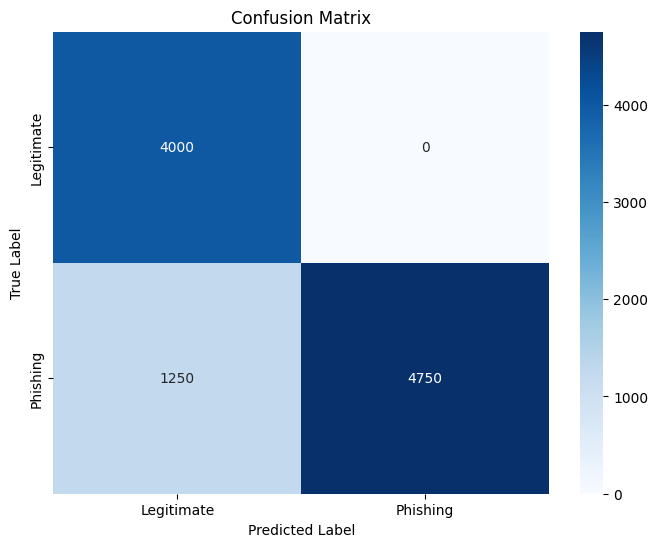


Results for Dataset1 → Dataset2:
  Accuracy:  0.8750
  Precision: 1.0000
  Recall:    0.7917
  F1 Score:  0.8837
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset1 → Dataset3
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert
✓ Using existing model for Dataset1

--- Testing on: Dataset3 ---


Evaluating: 100%|██████████| 2386/2386 [21:19<00:00,  1.86it/s]



Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.62      0.96      0.75     17308
    Phishing       0.93      0.51      0.66     20856

    accuracy                           0.71     38164
   macro avg       0.78      0.73      0.71     38164
weighted avg       0.79      0.71      0.70     38164



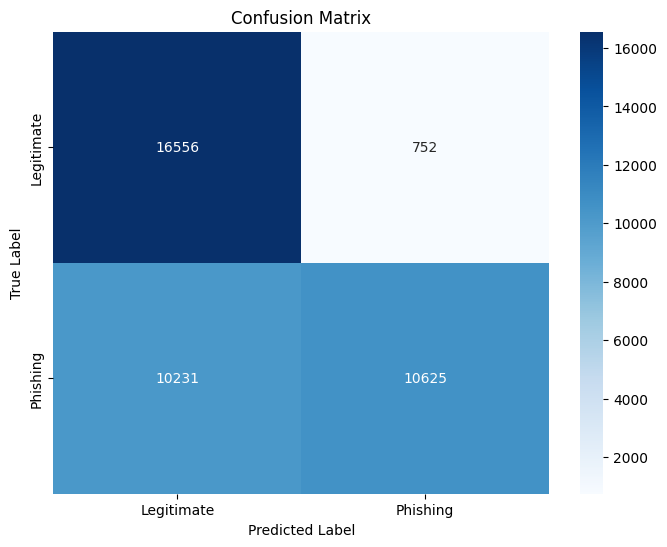


Results for Dataset1 → Dataset3:
  Accuracy:  0.7122
  Precision: 0.9339
  Recall:    0.5094
  F1 Score:  0.6593
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

✓ Dataset1 experiments complete!


In [ ]:

# --------------------------------------------------
# EXPERIMENT 1: Train on Dataset1
# --------------------------------------------------
train_name = 'Dataset1'
test_names = ['Dataset1', 'Dataset2', 'Dataset3']

for test_name in test_names:
    experiment_key = f"{train_name} → {test_name}"

    # Skip if already done
    if experiment_key in results:
        print(f"✓ Skipping {experiment_key} (already completed)")
        continue

    # Run experiment
    metrics = run_single_experiment(
        train_name,
        test_name,
        datasets,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        force_retrain=FORCE_RETRAIN
    )

    # Save results immediately
    results[experiment_key] = metrics
    save_results(results, 'bert_cross_dataset_results.pkl')

    # Also save as CSV incrementally
    results_df = create_results_table(results)
    results_df.to_csv(f'{RESULTS_DIR}/bert_results_progress.csv', index=False)

print("\n✓ Dataset1 experiments complete!")


EXPERIMENT: Dataset2 → Dataset1
✗ Model not found at: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert

TRAINING NEW MODEL: Dataset2

Training BERT Model
Training samples: 8000
Validation samples: 2000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


  Train Loss: 0.0192
  Val Loss: 0.0001
  → Best model so far!

Epoch 2/3


Validation: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]


  Train Loss: 0.0001
  Val Loss: 0.0000
  → Best model so far!

Epoch 3/3


Validation: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]

  Train Loss: 0.0000
  Val Loss: 0.0000
  → Best model so far!


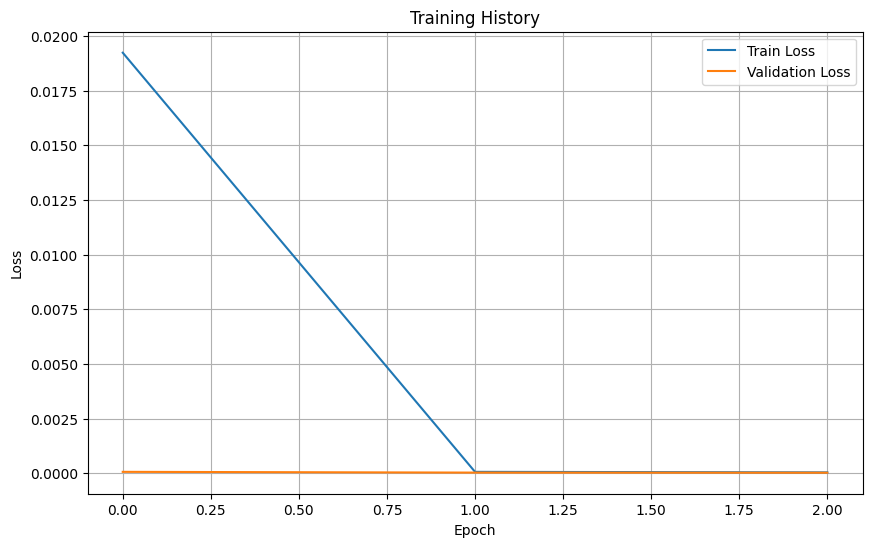

✓ Model saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert

--- Testing on: Dataset1 ---


Evaluating: 100%|██████████| 250/250 [02:06<00:00,  1.97it/s]


Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.00      0.00      0.00      2000
    Phishing       0.50      1.00      0.67      1998

    accuracy                           0.50      3998
   macro avg       0.25      0.50      0.33      3998
weighted avg       0.25      0.50      0.33      3998



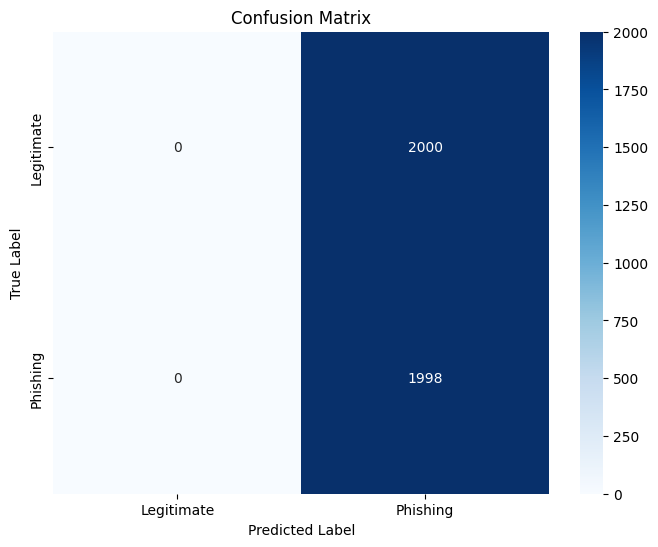


Results for Dataset2 → Dataset1:
  Accuracy:  0.4997
  Precision: 0.4997
  Recall:    1.0000
  F1 Score:  0.6664
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset2 → Dataset2
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert
✓ Using existing model for Dataset2

--- Testing on: Dataset2 ---


Evaluating: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]



Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00       800
    Phishing       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



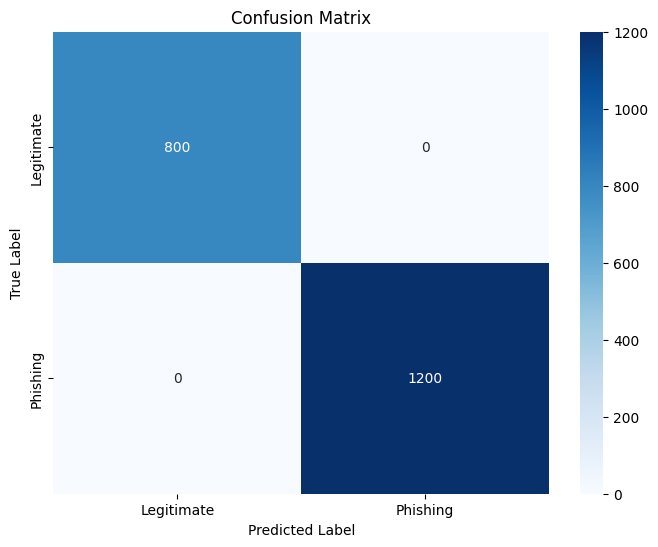


Results for Dataset2 → Dataset2:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset2 → Dataset3
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert
✓ Using existing model for Dataset2

--- Testing on: Dataset3 ---


Evaluating: 100%|██████████| 2386/2386 [21:07<00:00,  1.88it/s]



Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.00      0.00      0.00     17308
    Phishing       0.55      1.00      0.71     20856

    accuracy                           0.55     38164
   macro avg       0.27      0.50      0.35     38164
weighted avg       0.30      0.55      0.39     38164



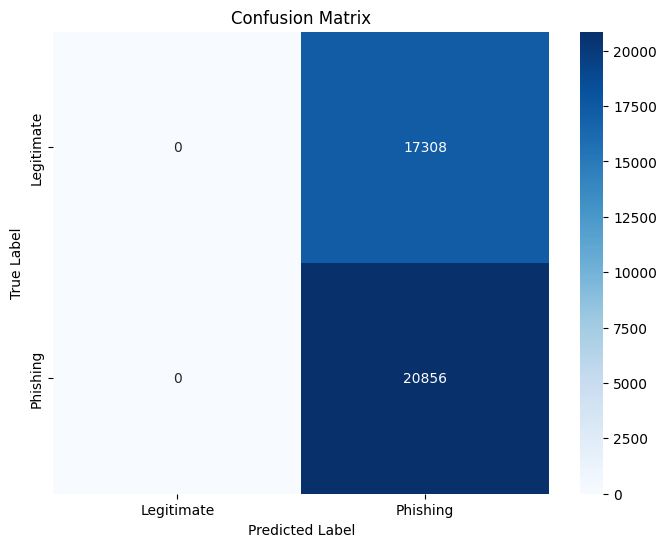


Results for Dataset2 → Dataset3:
  Accuracy:  0.5465
  Precision: 0.5465
  Recall:    1.0000
  F1 Score:  0.7067
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

✓ Dataset2 experiments complete!


In [ ]:
# --------------------------------------------------
# EXPERIMENT 2: Train on Dataset2
# --------------------------------------------------
train_name = 'Dataset2'
test_names = ['Dataset1', 'Dataset2', 'Dataset3']

for test_name in test_names:
    experiment_key = f"{train_name} → {test_name}"

    if experiment_key in results:
        print(f"✓ Skipping {experiment_key} (already completed)")
        continue

    metrics = run_single_experiment(
        train_name,
        test_name,
        datasets,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        force_retrain=FORCE_RETRAIN
    )

    results[experiment_key] = metrics
    save_results(results, 'bert_cross_dataset_results.pkl')

    results_df = create_results_table(results)
    results_df.to_csv(f'{RESULTS_DIR}/bert_results_progress.csv', index=False)

print("\n✓ Dataset2 experiments complete!")


EXPERIMENT: Dataset3 → Dataset1
✗ Model not found at: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset3_bert

TRAINING NEW MODEL: Dataset3

Training BERT Model
Training samples: 30531
Validation samples: 7633


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 478/478 [04:26<00:00,  1.79it/s]


  Train Loss: 0.0446
  Val Loss: 0.0162
  → Best model so far!

Epoch 2/3


Validation: 100%|██████████| 478/478 [04:26<00:00,  1.80it/s]


  Train Loss: 0.0074
  Val Loss: 0.0156
  → Best model so far!

Epoch 3/3


Validation: 100%|██████████| 478/478 [04:26<00:00,  1.79it/s]


  Train Loss: 0.0017
  Val Loss: 0.0171


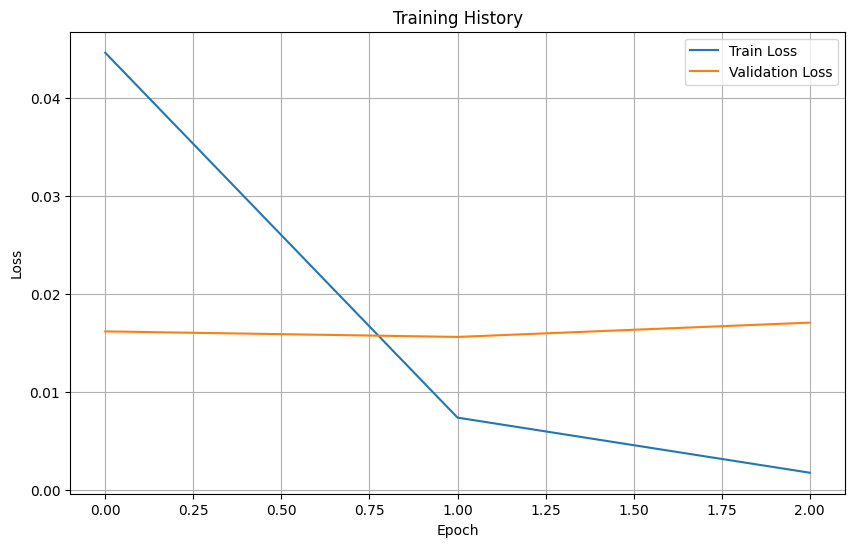

✓ Model saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset3_bert

--- Testing on: Dataset1 ---


Evaluating: 100%|██████████| 250/250 [02:14<00:00,  1.86it/s]


Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.66      0.93      0.77      2000
    Phishing       0.87      0.51      0.65      1998

    accuracy                           0.72      3998
   macro avg       0.76      0.72      0.71      3998
weighted avg       0.76      0.72      0.71      3998



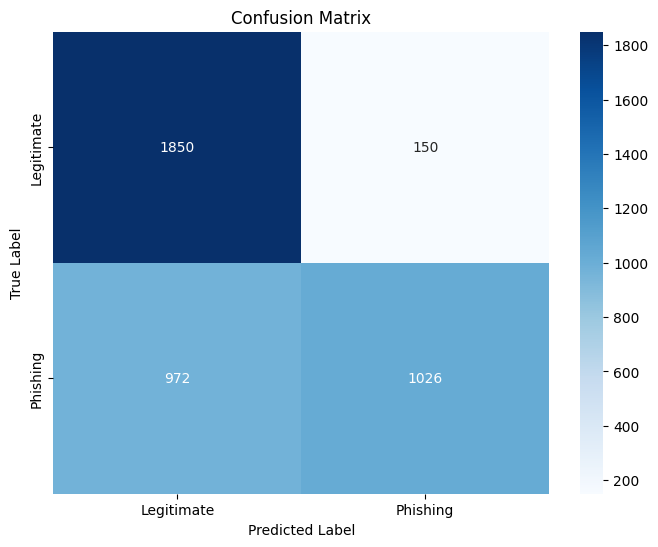


Results for Dataset3 → Dataset1:
  Accuracy:  0.7194
  Precision: 0.8724
  Recall:    0.5135
  F1 Score:  0.6465
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset3 → Dataset2
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset3_bert
✓ Using existing model for Dataset3

--- Testing on: Dataset2 ---


Evaluating: 100%|██████████| 625/625 [05:02<00:00,  2.07it/s]



Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.47      1.00      0.64      4000
    Phishing       1.00      0.24      0.39      6000

    accuracy                           0.54     10000
   macro avg       0.73      0.62      0.51     10000
weighted avg       0.79      0.54      0.49     10000



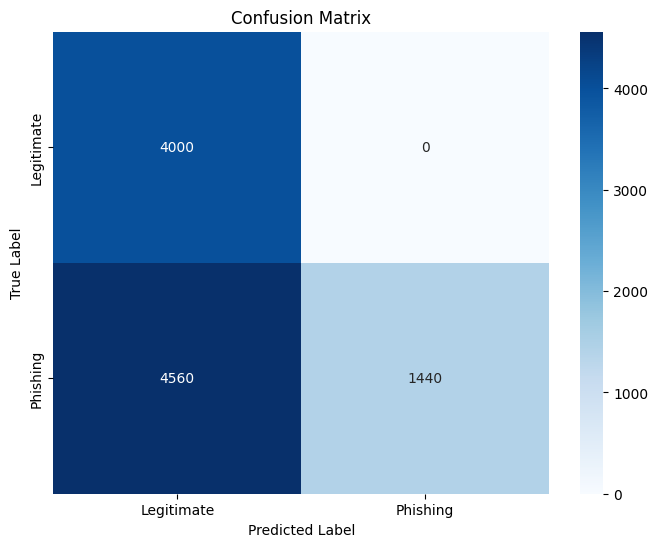


Results for Dataset3 → Dataset2:
  Accuracy:  0.5440
  Precision: 1.0000
  Recall:    0.2400
  F1 Score:  0.3871
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset3 → Dataset3
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset3_bert
✓ Using existing model for Dataset3

--- Testing on: Dataset3 ---


Evaluating: 100%|██████████| 478/478 [04:26<00:00,  1.79it/s]



Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      3462
    Phishing       1.00      1.00      1.00      4171

    accuracy                           1.00      7633
   macro avg       1.00      1.00      1.00      7633
weighted avg       1.00      1.00      1.00      7633



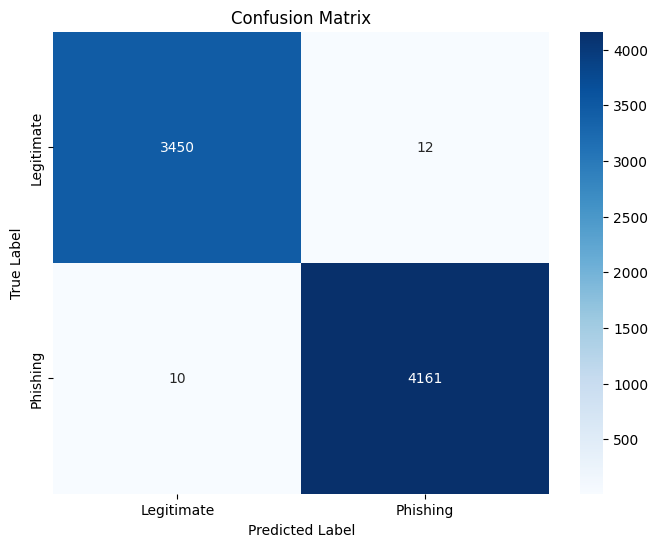


Results for Dataset3 → Dataset3:
  Accuracy:  0.9971
  Precision: 0.9971
  Recall:    0.9976
  F1 Score:  0.9974
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

✓ Dataset3 experiments complete!


In [ ]:
# --------------------------------------------------
# EXPERIMENT 3: Train on Dataset3
# --------------------------------------------------
train_name = 'Dataset3'
test_names = ['Dataset1', 'Dataset2', 'Dataset3']

for test_name in test_names:
    experiment_key = f"{train_name} → {test_name}"

    if experiment_key in results:
        print(f"✓ Skipping {experiment_key} (already completed)")
        continue

    metrics = run_single_experiment(
        train_name,
        test_name,
        datasets,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        force_retrain=FORCE_RETRAIN
    )

    results[experiment_key] = metrics
    save_results(results, 'bert_cross_dataset_results.pkl')

    results_df = create_results_table(results)
    results_df.to_csv(f'{RESULTS_DIR}/bert_results_progress.csv', index=False)

print("\n✓ Dataset3 experiments complete!")


GENERATING FINAL RESULTS
✓ Results loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

Final Results Table:
Train Dataset Test Dataset Accuracy Precision Recall F1 Score
     Dataset1     Dataset1   0.9950    1.0000 0.9900   0.9950
     Dataset1     Dataset2   0.8750    1.0000 0.7917   0.8837
     Dataset1     Dataset3   0.7122    0.9339 0.5094   0.6593
     Dataset2     Dataset1   0.4997    0.4997 1.0000   0.6664
     Dataset2     Dataset2   1.0000    1.0000 1.0000   1.0000
     Dataset2     Dataset3   0.5465    0.5465 1.0000   0.7067
     Dataset3     Dataset1   0.7194    0.8724 0.5135   0.6465
     Dataset3     Dataset2   0.5440    1.0000 0.2400   0.3871
     Dataset3     Dataset3   0.9971    0.9971 0.9976   0.9974


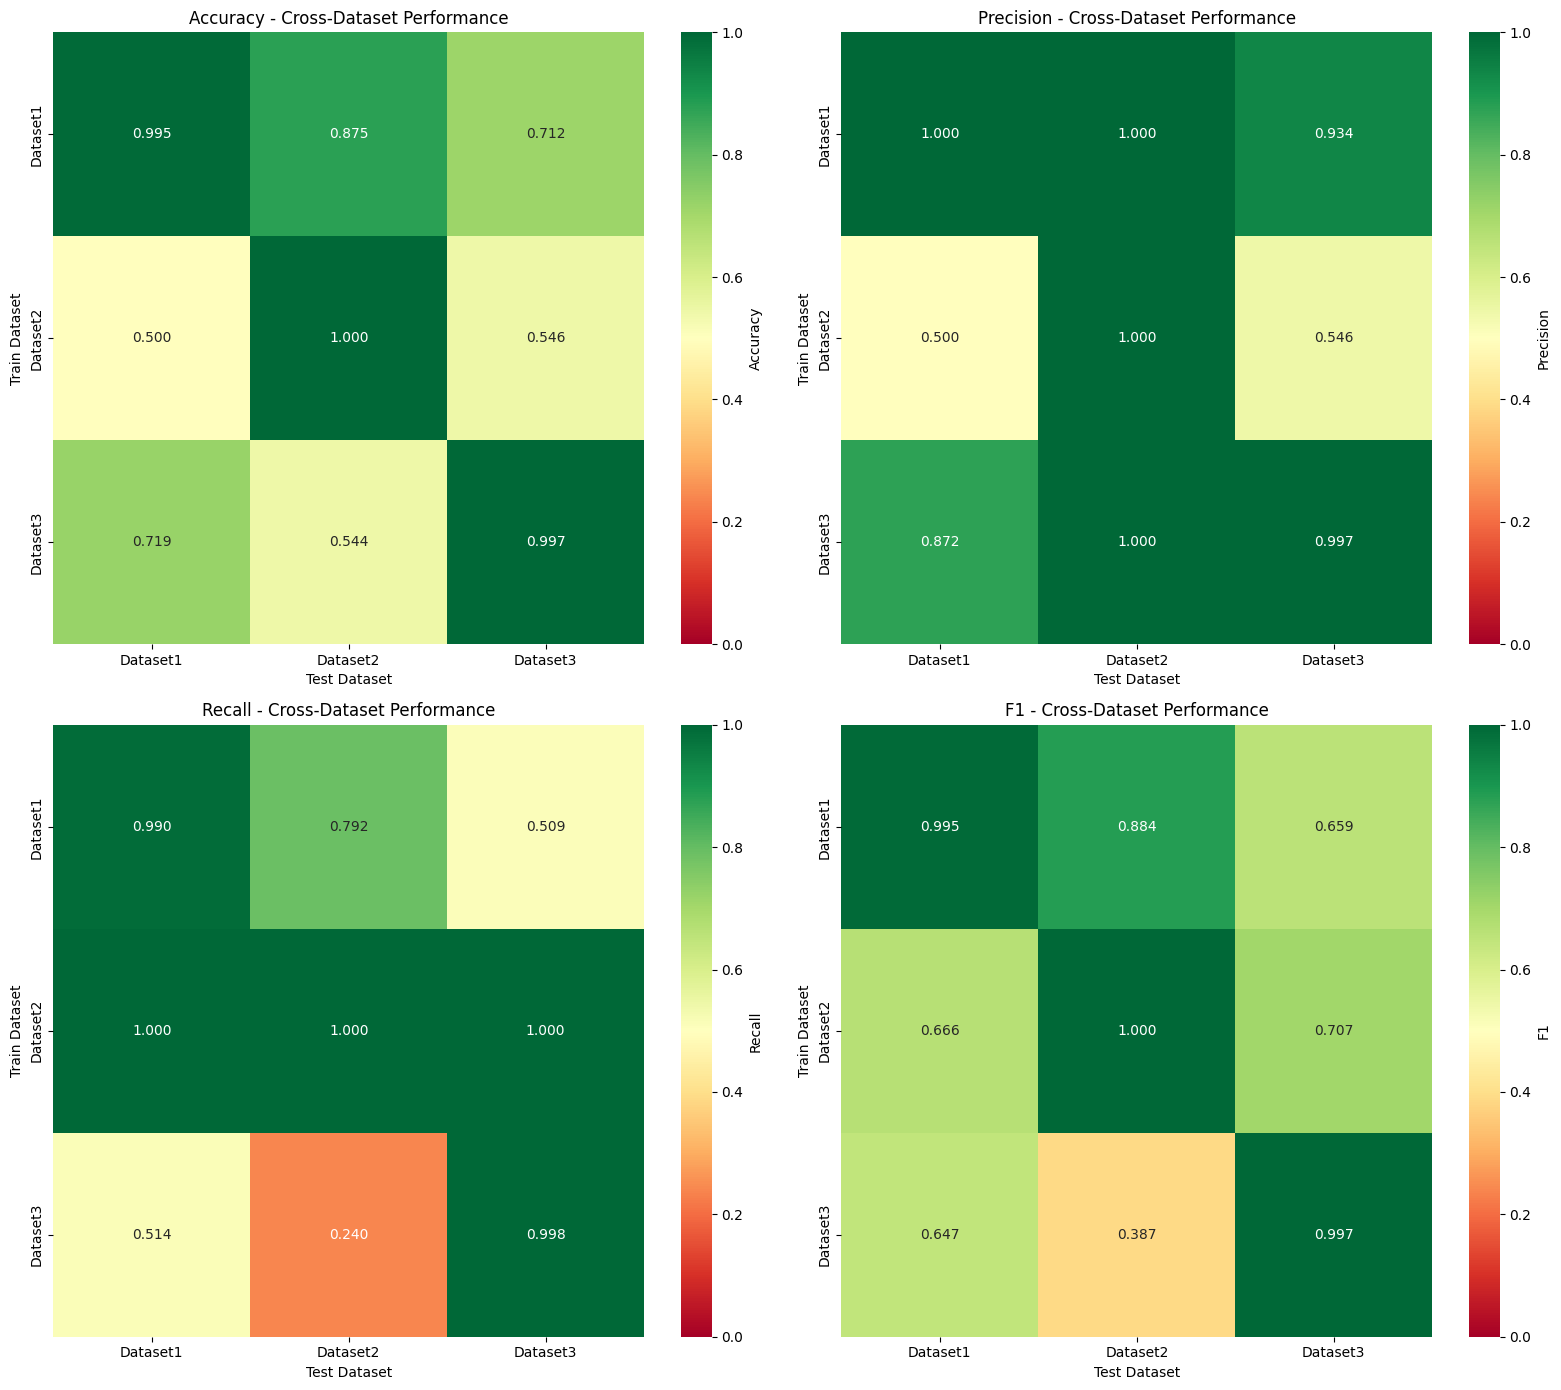


=== Performance Drop Analysis ===

Dataset1 (Within-dataset F1: 0.9950):
  → Dataset2: F1 = 0.8837 (drop: 0.1113, 11.2%)
  → Dataset3: F1 = 0.6593 (drop: 0.3357, 33.7%)

Dataset2 (Within-dataset F1: 1.0000):
  → Dataset1: F1 = 0.6664 (drop: 0.3336, 33.4%)
  → Dataset3: F1 = 0.7067 (drop: 0.2933, 29.3%)

Dataset3 (Within-dataset F1: 0.9974):
  → Dataset1: F1 = 0.6465 (drop: 0.3509, 35.2%)
  → Dataset2: F1 = 0.3871 (drop: 0.6103, 61.2%)

✓ ALL EXPERIMENTS COMPLETE!


In [ ]:
# --------------------------------------------------
# FINAL: Generate all visualizations
# --------------------------------------------------
print("\n" + "="*70)
print("GENERATING FINAL RESULTS")
print("="*70)

# Load all results
results = load_results('bert_cross_dataset_results.pkl')

# Create final results table
results_df = create_results_table(results)
print("\nFinal Results Table:")
print(results_df.to_string(index=False))

# Save final CSV
results_df.to_csv(f'{RESULTS_DIR}/bert_cross_dataset_results_FINAL.csv', index=False)

# Plot heatmaps
plot_cross_dataset_results(results)

# Performance drop analysis
print("\n=== Performance Drop Analysis ===")
for train_ds in ['Dataset1', 'Dataset2', 'Dataset3']:
    within_key = f"{train_ds} → {train_ds}"
    if within_key in results:
        within_f1 = results[within_key]['f1']

        print(f"\n{train_ds} (Within-dataset F1: {within_f1:.4f}):")

        for test_ds in ['Dataset1', 'Dataset2', 'Dataset3']:
            if test_ds != train_ds:
                cross_key = f"{train_ds} → {test_ds}"
                if cross_key in results:
                    cross_f1 = results[cross_key]['f1']
                    drop = within_f1 - cross_f1
                    drop_pct = (drop / within_f1) * 100

                    print(f"  → {test_ds}: F1 = {cross_f1:.4f} (drop: {drop:.4f}, {drop_pct:.1f}%)")

print("\n✓ ALL EXPERIMENTS COMPLETE!")


In [ ]:
(44.9/2 + 62.7/2 + 96.4/2) / 3

34.0

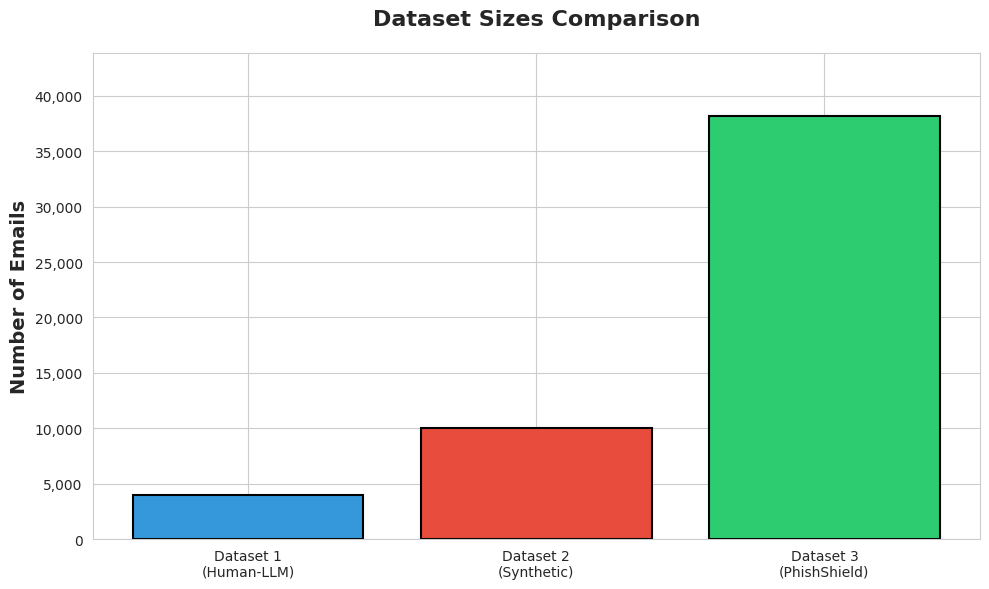

Dataset sizes chart saved


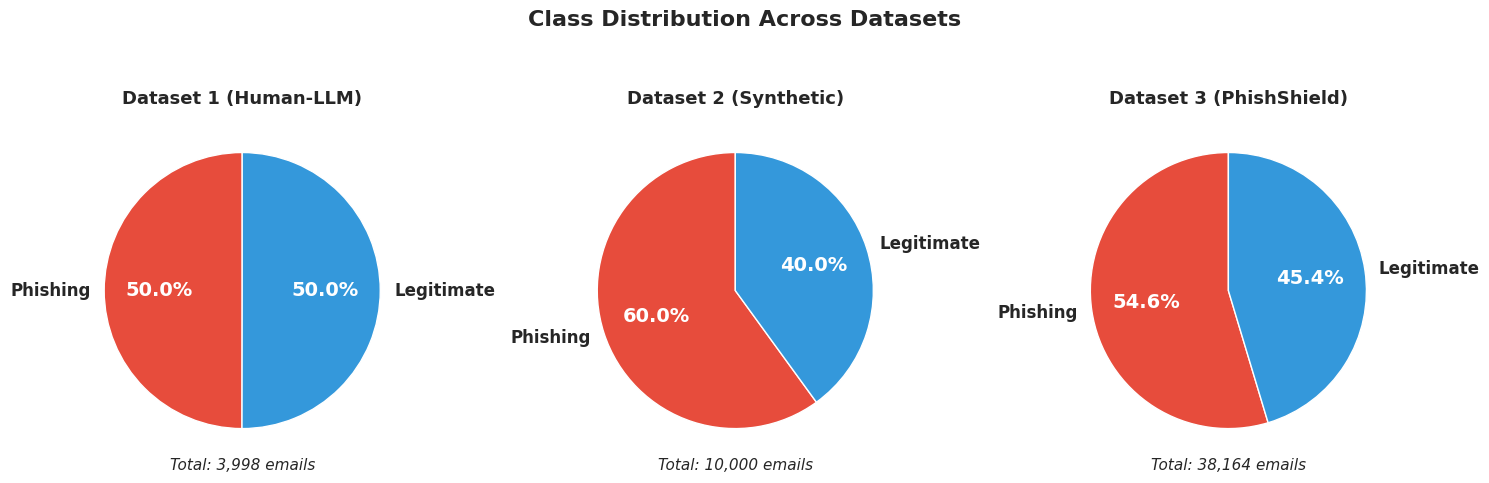

 Class distribution charts saved


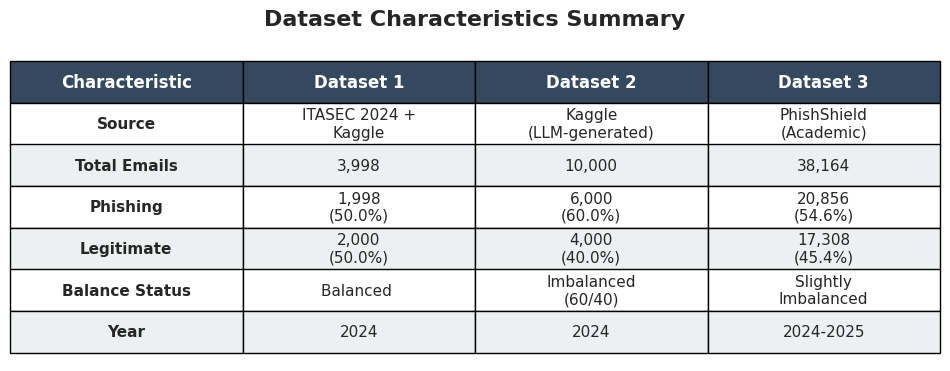

✓ Dataset characteristics table saved


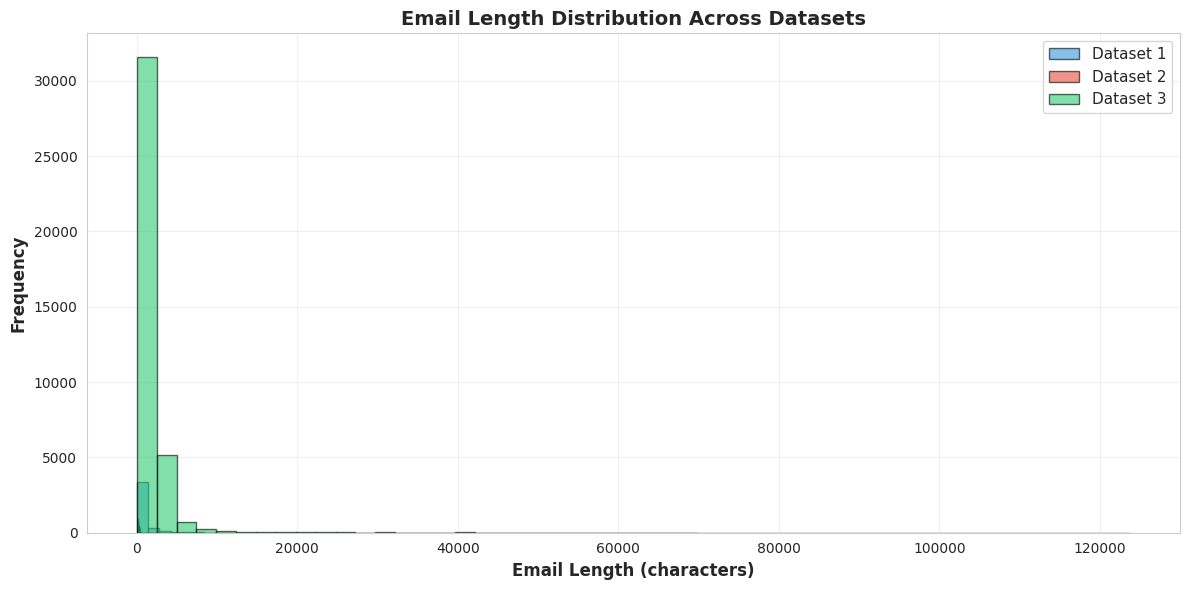

 Email length distribution saved

 ALL VISUALIZATIONS SAVED TO: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results


In [ ]:
# ============================================================================
# DATASET VISUALIZATION CODE (Run after loading datasets)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1. DATASET SIZES BAR CHART
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

datasets_names = ['Dataset 1\n(Human-LLM)', 'Dataset 2\n(Synthetic)', 'Dataset 3\n(PhishShield)']
datasets_sizes = [len(df1), len(df2), len(df3)]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = ax.bar(datasets_names, datasets_sizes, color=colors, edgecolor='black', linewidth=1.5)



ax.set_ylabel('Number of Emails', fontsize=14, fontweight='bold')
ax.set_title('Dataset Sizes Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, max(datasets_sizes) * 1.15)

# Format y-axis with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/dataset_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

print("Dataset sizes chart saved")

# 2. CLASS DISTRIBUTION PIE CHARTS
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [
    ('Dataset 1 (Human-LLM)', df1),
    ('Dataset 2 (Synthetic)', df2),
    ('Dataset 3 (PhishShield)', df3)
]

colors_pie = ['#e74c3c', '#3498db']  # Red for phishing, blue for legitimate
labels = ['Phishing', 'Legitimate']

for idx, (name, df) in enumerate(datasets):
    phishing_count = sum(df['label'] == 1)
    legit_count = sum(df['label'] == 0)
    sizes = [phishing_count, legit_count]

    # Create pie chart
    wedges, texts, autotexts = axes[idx].pie(
        sizes,
        labels=labels,
        colors=colors_pie,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'}
    )

    # Make percentage text white and bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(14)
        autotext.set_fontweight('bold')

    axes[idx].set_title(name, fontsize=13, fontweight='bold', pad=10)

    # Add sample counts below title
    axes[idx].text(0, -1.3, f'Total: {len(df):,} emails',
                   ha='center', fontsize=11, style='italic')

plt.suptitle('Class Distribution Across Datasets',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/class_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Class distribution charts saved")

# 3. DATASET CHARACTERISTICS TABLE (Visual)
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

# Create table data
table_data = [
    ['Characteristic', 'Dataset 1', 'Dataset 2', 'Dataset 3'],
    ['Source', 'ITASEC 2024 +\nKaggle', 'Kaggle\n(LLM-generated)', 'PhishShield\n(Academic)'],
    ['Total Emails', f'{len(df1):,}', f'{len(df2):,}', f'{len(df3):,}'],
    ['Phishing', f'{sum(df1["label"]==1):,}\n({sum(df1["label"]==1)/len(df1)*100:.1f}%)',
                 f'{sum(df2["label"]==1):,}\n({sum(df2["label"]==1)/len(df2)*100:.1f}%)',
                 f'{sum(df3["label"]==1):,}\n({sum(df3["label"]==1)/len(df3)*100:.1f}%)'],
    ['Legitimate', f'{sum(df1["label"]==0):,}\n({sum(df1["label"]==0)/len(df1)*100:.1f}%)',
                   f'{sum(df2["label"]==0):,}\n({sum(df2["label"]==0)/len(df2)*100:.1f}%)',
                   f'{sum(df3["label"]==0):,}\n({sum(df3["label"]==0)/len(df3)*100:.1f}%)'],
    ['Balance Status', 'Balanced ', 'Imbalanced\n(60/40)', 'Slightly\nImbalanced'],
    ['Year', '2024', '2024', '2024-2025']
]

# Create table
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#34495e')
    cell.set_text_props(weight='bold', color='white', fontsize=12)

# Style data rows with alternating colors
for i in range(1, len(table_data)):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('#ffffff')

        # Bold first column
        if j == 0:
            cell.set_text_props(weight='bold')

plt.title('Dataset Characteristics Summary', fontsize=16, fontweight='bold', pad=20)
plt.savefig(f'{RESULTS_DIR}/dataset_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dataset characteristics table saved")

# 4. OPTIONAL: Sample email lengths distribution
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Calculate email lengths
df1['email_length'] = df1['email_text'].str.len()
df2['email_length'] = df2['email_text'].str.len()
df3['email_length'] = df3['email_text'].str.len()

# Plot distributions
ax.hist(df1['email_length'], bins=50, alpha=0.6, label='Dataset 1', color='#3498db', edgecolor='black')
ax.hist(df2['email_length'], bins=50, alpha=0.6, label='Dataset 2', color='#e74c3c', edgecolor='black')
ax.hist(df3['email_length'], bins=50, alpha=0.6, label='Dataset 3', color='#2ecc71', edgecolor='black')

ax.set_xlabel('Email Length (characters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Email Length Distribution Across Datasets', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/email_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Email length distribution saved")

print("\n" + "="*70)
print(" ALL VISUALIZATIONS SAVED TO:", RESULTS_DIR)
print("="*70)


In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from captum.attr import LayerIntegratedGradients
from tqdm import tqdm



def get_global_keywords(df, text_col="email_text", label_col="label", top_k=400):
    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=5000,
        ngram_range=(1, 2)
    )

    X = vectorizer.fit_transform(df[text_col])
    y = df[label_col]

    chi_scores, _ = chi2(X, y)
    tokens = np.array(vectorizer.get_feature_names_out())

    # Top-k words correlated with phishing
    top_tokens = tokens[np.argsort(chi_scores)][-top_k:]

    return set(top_tokens)


def get_ig_for_text(model, tokenizer, lig, text, candidate_tokens, target_class=1, n_steps=20, device="cuda"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    input_ids = inputs["input_ids"].to(device)
    baseline = torch.zeros_like(input_ids)

    attributions = lig.attribute(
        inputs=input_ids,
        baselines=baseline,
        target=target_class,
        n_steps=n_steps,
        return_convergence_delta=False
    )

    attributions = attributions.sum(dim=-1).squeeze().detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    word_scores = {}
    for tok, score in zip(tokens, attributions):
        clean_tok = tok.replace("##", "")
        if clean_tok.lower() in candidate_tokens:
            word_scores.setdefault(clean_tok, []).append(float(score))

    return word_scores


def run_optimized_ig(df, model, tokenizer, candidate_tokens, sample_size=400, device="cuda"):
    # Stratified sampling
    df_sample = (
        df.groupby("label")
          .sample(n=sample_size // 2, random_state=42)
          .reset_index(drop=True)
    )

    # Wrap model for Captum
    def forward_wrapper(input_ids, attention_mask=None):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

    # IG on embedding layer
    lig = LayerIntegratedGradients(forward_wrapper, model.bert.embeddings)

    agg_scores = {}

    for text, label in tqdm(zip(df_sample["email_text"], df_sample["label"]), total=len(df_sample)):
        scores = get_ig_for_text(model, tokenizer, lig, text, candidate_tokens)
        for tok, vals in scores.items():
            agg_scores.setdefault(tok, []).extend(vals)

    final_scores = {tok: np.mean(vals) for tok, vals in agg_scores.items()}

    final_df = (
        pd.DataFrame({
            "token": list(final_scores.keys()),
            "score": list(final_scores.values())
        }).sort_values("score", ascending=False)
    )

    return final_df



# ============================================================================
# RUN OPTIMIZED IG FOR ALL THREE MODELS
# ============================================================================

device = "cuda" if torch.cuda.is_available() else "cpu"

datasets_info = [
    ("Dataset1", "/content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert/",
                 "/content/drive/MyDrive/CleanedProjectDatasets/Dataset1.csv"),
    ("Dataset2", "/content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert/",
                 "/content/drive/MyDrive/CleanedProjectDatasets/Dataset2.csv"),
    ("Dataset3", "/content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset3_bert/",
                 "/content/drive/MyDrive/CleanedProjectDatasets/Dataset3.csv")
]

all_results = {}

for ds_name, model_path, data_path in datasets_info:
    print(f"\n{'='*70}")
    print(f"ANALYZING {ds_name}")
    print(f"{'='*70}")

    # Load model
    print(f"Loading model from {model_path}...")
    model = BertForSequenceClassification.from_pretrained(model_path).to(device)
    tokenizer = BertTokenizer.from_pretrained(model_path)

    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)

    # Step 1: Get candidate keywords
    print("Step 1: Extracting global keywords...")
    candidate_tokens = get_global_keywords(df, text_col="email_text", label_col="label", top_k=400)
    print(f"  → Found {len(candidate_tokens)} candidate keywords")

    # Step 2: Run Integrated Gradients
    print("Step 2: Running Integrated Gradients (this takes ~3-5 minutes)...")
    result_df = run_optimized_ig(df, model, tokenizer, candidate_tokens, sample_size=400)

    # Store results
    all_results[ds_name] = result_df

    print(f"\n✓ {ds_name} complete!")
    print(f"Top 10 words:")
    print(result_df.head(10).to_string(index=False))

    # Save individual results
    result_df.to_csv(f'{RESULTS_DIR}/{ds_name}_feature_importance.csv', index=False)
    print(f"  → Saved to {RESULTS_DIR}/{ds_name}_feature_importance.csv")

print("\n" + "="*70)
print("✓ ALL ANALYSES COMPLETE!")
print("="*70)




ANALYZING Dataset1
Loading model from /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert/...
Loading data from /content/drive/MyDrive/CleanedProjectDatasets/Dataset1.csv...
Step 1: Extracting global keywords...
  → Found 400 candidate keywords
Step 2: Running Integrated Gradients (this takes ~3-5 minutes)...


100%|██████████| 400/400 [01:41<00:00,  3.94it/s]



✓ Dataset1 complete!
Top 10 words:
       token    score
transactions 0.339543
     noticed 0.262813
    purchase 0.230128
    register 0.174246
    personal 0.162322
    settings 0.159055
     shipped 0.149000
        card 0.142178
    attached 0.126908
 immediately 0.114037
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset1_feature_importance.csv

ANALYZING Dataset2
Loading model from /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert/...
Loading data from /content/drive/MyDrive/CleanedProjectDatasets/Dataset2.csv...
Step 1: Extracting global keywords...
  → Found 400 candidate keywords
Step 2: Running Integrated Gradients (this takes ~3-5 minutes)...


100%|██████████| 400/400 [00:50<00:00,  7.96it/s]



✓ Dataset2 complete!
Top 10 words:
       token    score
        sync 0.222571
registration 0.127461
      client 0.119994
    document 0.119764
      shared 0.115150
      timing 0.104682
   equipment 0.102495
        feel 0.100262
 performance 0.098520
       event 0.097300
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset2_feature_importance.csv

ANALYZING Dataset3
Loading model from /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset3_bert/...
Loading data from /content/drive/MyDrive/CleanedProjectDatasets/Dataset3.csv...
Step 1: Extracting global keywords...
  → Found 400 candidate keywords
Step 2: Running Integrated Gradients (this takes ~3-5 minutes)...


100%|██████████| 400/400 [02:32<00:00,  2.63it/s]


✓ Dataset3 complete!
Top 10 words:
  token    score
  women 0.857511
 hilton 0.809990
    men 0.763460
   love 0.693846
  paris 0.619026
   life 0.591091
  watch 0.483104
   gain 0.461144
quality 0.447631
 inches 0.414863
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset3_feature_importance.csv

✓ ALL ANALYSES COMPLETE!


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 131.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-py

NameError: name 'all_results' is not defined

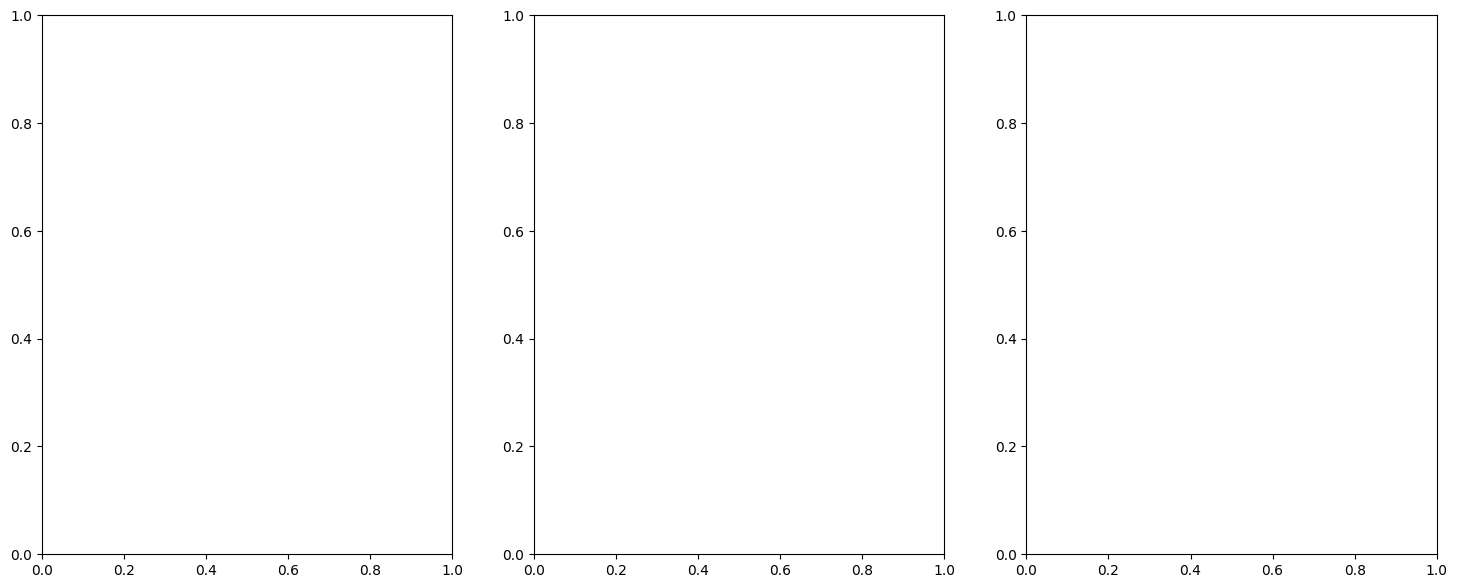

In [ ]:
# ============================================================================
# VISUALIZE TOP WORDS FOR ALL THREE MODELS
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

for idx, (ds_name, result_df) in enumerate(all_results.items()):
    # Get top 15 words
    top_15 = result_df.head(15)

    # Create horizontal bar chart
    y_pos = np.arange(len(top_15))
    axes[idx].barh(y_pos, top_15['score'], color='#3498db', edgecolor='black', linewidth=1)
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(top_15['token'], fontsize=10)
    axes[idx].set_xlabel('IG Attribution Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{ds_name} Model\nTop 15 Features', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance Across Models (Integrated Gradients + Chi²)',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/feature_importance_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved!")

In [ ]:
# ============================================================================
# FEATURE OVERLAP ANALYSIS (Replicating Original Study)
# ============================================================================

def analyze_feature_overlap(all_results, top_n=15):
    """
    Compare top features across datasets
    (Replicates the original URL study's methodology)
    """

    print("\n" + "="*70)
    print("FEATURE OVERLAP ANALYSIS")
    print("Comparing top features across datasets")
    print("="*70)

    # Get top N features for each dataset
    top_features = {}
    for ds_name, result_df in all_results.items():
        top_features[ds_name] = set(result_df.head(top_n)['token'].str.lower())

    # Calculate pairwise overlaps
    dataset_names = list(top_features.keys())

    print(f"\nTop {top_n} Features per Model:")
    for ds_name in dataset_names:
        print(f"\n{ds_name}:")
        features_list = list(all_results[ds_name].head(top_n)['token'])
        for i, feat in enumerate(features_list, 1):
            print(f"  {i:2d}. {feat}")

    print("\n" + "-"*70)
    print("OVERLAP ANALYSIS")
    print("-"*70)

    # Universal features (appear in all 3)
    universal = top_features['Dataset1'] & top_features['Dataset2'] & top_features['Dataset3']

    # Pairwise overlaps
    overlap_12 = top_features['Dataset1'] & top_features['Dataset2']
    overlap_13 = top_features['Dataset1'] & top_features['Dataset3']
    overlap_23 = top_features['Dataset2'] & top_features['Dataset3']

    # Dataset-specific (unique to each)
    unique_1 = top_features['Dataset1'] - (top_features['Dataset2'] | top_features['Dataset3'])
    unique_2 = top_features['Dataset2'] - (top_features['Dataset1'] | top_features['Dataset3'])
    unique_3 = top_features['Dataset3'] - (top_features['Dataset1'] | top_features['Dataset2'])

    print(f"\nUniversal Features (appear in all 3 models): {len(universal)}/{top_n}")
    if universal:
        print(f"  → {sorted(universal)}")
    else:
        print(f"  → NONE! (This is a RED FLAG - no universal patterns learned)")

    print(f"\nPairwise Overlaps:")
    print(f"  Dataset1 ∩ Dataset2: {len(overlap_12)}/{top_n} ({len(overlap_12)/top_n*100:.0f}%)")
    print(f"    → {sorted(overlap_12)}")
    print(f"  Dataset1 ∩ Dataset3: {len(overlap_13)}/{top_n} ({len(overlap_13)/top_n*100:.0f}%)")
    print(f"    → {sorted(overlap_13)}")
    print(f"  Dataset2 ∩ Dataset3: {len(overlap_23)}/{top_n} ({len(overlap_23)/top_n*100:.0f}%)")
    print(f"    → {sorted(overlap_23)}")

    print(f"\nDataset-Specific Features (unique to each):")
    print(f"  Dataset1 only: {len(unique_1)}/{top_n} ({len(unique_1)/top_n*100:.0f}%)")
    if unique_1:
        print(f"    → {sorted(unique_1)}")
    print(f"  Dataset2 only: {len(unique_2)}/{top_n} ({len(unique_2)/top_n*100:.0f}%)")
    if unique_2:
        print(f"    → {sorted(unique_2)}")
    print(f"  Dataset3 only: {len(unique_3)}/{top_n} ({len(unique_3)/top_n*100:.0f}%)")
    if unique_3:
        print(f"    → {sorted(unique_3)}")

    # Summary statistics
    avg_overlap = (len(overlap_12) + len(overlap_13) + len(overlap_23)) / 3
    total_unique = len(unique_1) + len(unique_2) + len(unique_3)

    print("\n" + "-"*70)
    print("SUMMARY STATISTICS")
    print("-"*70)
    print(f"Average pairwise overlap: {avg_overlap:.1f}/{top_n} ({avg_overlap/top_n*100:.0f}%)")
    print(f"Total dataset-specific features: {total_unique}/{top_n*3} ({total_unique/(top_n*3)*100:.0f}%)")
    print(f"Universal features: {len(universal)}/{top_n} ({len(universal)/top_n*100:.0f}%)")

    return {
        'universal': universal,
        'overlap_12': overlap_12,
        'overlap_13': overlap_13,
        'overlap_23': overlap_23,
        'unique_1': unique_1,
        'unique_2': unique_2,
        'unique_3': unique_3,
        'avg_overlap_pct': avg_overlap/top_n*100,
        'dataset_specific_pct': total_unique/(top_n*3)*100
    }

# Run the analysis
overlap_results = analyze_feature_overlap(all_results, top_n=15)


FEATURE OVERLAP ANALYSIS
Comparing top features across datasets

Top 15 Features per Model:

Dataset1:
   1. transactions
   2. noticed
   3. purchase
   4. register
   5. personal
   6. settings
   7. shipped
   8. card
   9. attached
  10. immediately
  11. xp
  12. unusual
  13. avoid
  14. delivery
  15. interruption

Dataset2:
   1. sync
   2. registration
   3. client
   4. document
   5. shared
   6. timing
   7. equipment
   8. feel
   9. performance
  10. event
  11. deck
  12. research
  13. share
  14. warning
  15. free

Dataset3:
   1. women
   2. hilton
   3. men
   4. love
   5. paris
   6. life
   7. watch
   8. gain
   9. quality
  10. inches
  11. sex
  12. gains
  13. increase
  14. attack
  15. health

----------------------------------------------------------------------
OVERLAP ANALYSIS
----------------------------------------------------------------------

Universal Features (appear in all 3 models): 0/15
  → NONE! (This is a RED FLAG - no universal patterns lea

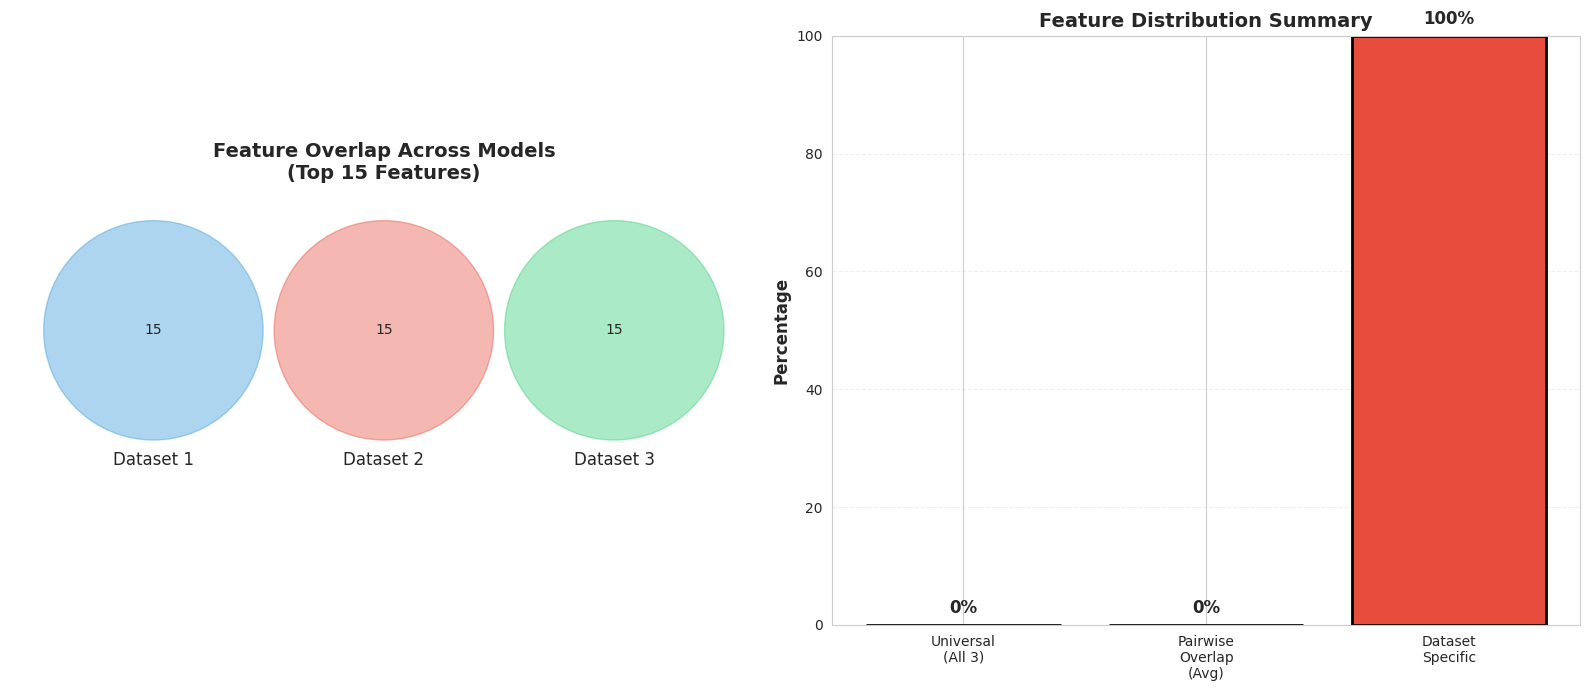

✓ Overlap visualization saved!


In [ ]:
# ============================================================================
# VISUALIZE FEATURE OVERLAP (Like the Original Paper)
# ============================================================================

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np

# Create Venn Diagram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: Venn diagram showing overlap
top_15_sets = {
    ds_name: set(result_df.head(15)['token'].str.lower())
    for ds_name, result_df in all_results.items()
}

venn = venn3(
    [top_15_sets['Dataset1'], top_15_sets['Dataset2'], top_15_sets['Dataset3']],
    ('Dataset 1', 'Dataset 2', 'Dataset 3'),
    ax=ax1
)

# Color the regions
if venn.get_patch_by_id('100'): venn.get_patch_by_id('100').set_color('#3498db')
if venn.get_patch_by_id('010'): venn.get_patch_by_id('010').set_color('#e74c3c')
if venn.get_patch_by_id('001'): venn.get_patch_by_id('001').set_color('#2ecc71')

ax1.set_title('Feature Overlap Across Models\n(Top 15 Features)',
              fontsize=14, fontweight='bold')

# Right: Bar chart of overlap percentages
categories = ['Universal\n(All 3)', 'Pairwise\nOverlap\n(Avg)', 'Dataset\nSpecific']
percentages = [
    len(overlap_results['universal']) / 15 * 100,
    overlap_results['avg_overlap_pct'],
    overlap_results['dataset_specific_pct']
]
colors_bar = ['#2ecc71', '#f39c12', '#e74c3c']

bars = ax2.bar(categories, percentages, color=colors_bar, edgecolor='black', linewidth=2)
ax2.set_ylabel('Percentage', fontsize=12, fontweight='bold')
ax2.set_title('Feature Distribution Summary', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{pct:.0f}%',
             ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/feature_overlap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Overlap visualization saved!")

In [ ]:
# ============================================================================
# COMPLETE CROSS-DATASET FEATURE ANALYSIS (9 EXPERIMENTS)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from captum.attr import LayerIntegratedGradients
from tqdm import tqdm

def get_global_keywords(df, text_col="email_text", label_col="label", top_k=400):
    """Extract top-k keywords correlated with phishing using Chi-squared"""
    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=5000,
        ngram_range=(1, 2)
    )

    X = vectorizer.fit_transform(df[text_col])
    y = df[label_col]
    chi_scores, _ = chi2(X, y)
    tokens = np.array(vectorizer.get_feature_names_out())
    top_tokens = tokens[np.argsort(chi_scores)][-top_k:]

    return set(top_tokens)

def get_ig_for_text(model, tokenizer, lig, text, candidate_tokens, target_class=1, n_steps=20, device="cuda"):
    """Get Integrated Gradients attribution for a single text"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    input_ids = inputs["input_ids"].to(device)
    baseline = torch.zeros_like(input_ids)

    attributions = lig.attribute(
        inputs=input_ids,
        baselines=baseline,
        target=target_class,
        n_steps=n_steps,
        return_convergence_delta=False
    )

    attributions = attributions.sum(dim=-1).squeeze().detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    word_scores = {}
    for tok, score in zip(tokens, attributions):
        clean_tok = tok.replace("##", "")
        if clean_tok.lower() in candidate_tokens:
            word_scores.setdefault(clean_tok, []).append(float(score))

    return word_scores

def run_optimized_ig(df, model, tokenizer, candidate_tokens, sample_size=400, device="cuda"):
    """Run IG on sampled emails and aggregate results"""
    # Stratified sampling
    df_sample = (
        df.groupby("label")
          .sample(n=min(sample_size // 2, len(df[df['label']==0]), len(df[df['label']==1])),
                  random_state=42)
          .reset_index(drop=True)
    )

    # Wrap model for Captum
    def forward_wrapper(input_ids, attention_mask=None):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

    # IG on embedding layer
    lig = LayerIntegratedGradients(forward_wrapper, model.bert.embeddings)

    agg_scores = {}

    for text in tqdm(df_sample["email_text"], desc="Processing emails"):
        scores = get_ig_for_text(model, tokenizer, lig, text, candidate_tokens, device=device)
        for tok, vals in scores.items():
            agg_scores.setdefault(tok, []).extend(vals)

    final_scores = {tok: np.mean(vals) for tok, vals in agg_scores.items()}

    final_df = (
        pd.DataFrame({
            "token": list(final_scores.keys()),
            "score": list(final_scores.values())
        }).sort_values("score", ascending=False)
    )

    return final_df

# ============================================================================
# MAIN: 9 CROSS-DATASET FEATURE ANALYSES
# ============================================================================

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset information
datasets_info = {
    "Dataset1": {
        "model_path": "/content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert/",
        "data_path": "/content/drive/MyDrive/CleanedProjectDatasets/Dataset1.csv"
    },
    "Dataset2": {
        "model_path": "/content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert/",
        "data_path": "/content/drive/MyDrive/CleanedProjectDatasets/Dataset2.csv"
    },
    "Dataset3": {
        "model_path": "/content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset3_bert/",
        "data_path": "/content/drive/MyDrive/CleanedProjectDatasets/Dataset3.csv"
    }
}

# Load all datasets first
print("Loading all datasets...")
all_dataframes = {}
for ds_name, info in datasets_info.items():
    all_dataframes[ds_name] = pd.read_csv(info["data_path"])
    print(f"  ✓ {ds_name}: {len(all_dataframes[ds_name])} emails")

# Storage for all 9 analyses
all_feature_results = {}

# Run 9 experiments: each model tested on each dataset
for train_ds in ["Dataset1", "Dataset2", "Dataset3"]:
    print(f"\n{'='*80}")
    print(f"LOADING MODEL TRAINED ON: {train_ds}")
    print(f"{'='*80}")

    # Load model (trained on train_ds)
    model_path = datasets_info[train_ds]["model_path"]
    model = BertForSequenceClassification.from_pretrained(model_path).to(device)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    print(f"✓ Model loaded from {model_path}")

    # Test this model on all 3 datasets
    for test_ds in ["Dataset1", "Dataset2", "Dataset3"]:
        experiment_key = f"{train_ds} → {test_ds}"

        print(f"\n{'-'*80}")
        print(f"EXPERIMENT: {experiment_key}")
        print(f"{'-'*80}")

        # Get test dataset
        df_test = all_dataframes[test_ds]

        # Step 1: Extract candidate keywords from TEST dataset
        print(f"Step 1: Extracting keywords from {test_ds}...")
        candidate_tokens = get_global_keywords(
            df_test,
            text_col="email_text",
            label_col="label",
            top_k=400
        )
        print(f"  → Found {len(candidate_tokens)} candidate keywords")

        # Step 2: Run IG to see which features THIS MODEL uses on THIS DATA
        print(f"Step 2: Analyzing which features {train_ds} model uses on {test_ds} data...")
        result_df = run_optimized_ig(
            df_test,
            model,
            tokenizer,
            candidate_tokens,
            sample_size=400,
            device=device
        )

        # Store results
        all_feature_results[experiment_key] = result_df

        # Display top 10
        print(f"\n✓ {experiment_key} complete!")
        print(f"Top 10 features:")
        print(result_df.head(10).to_string(index=False))

        # Save to file
        result_df.to_csv(f'{RESULTS_DIR}/{experiment_key.replace(" → ", "_to_")}_features.csv',
                        index=False)
        print(f"  → Saved to {RESULTS_DIR}/{experiment_key.replace(' → ', '_to_')}_features.csv")

print("\n" + "="*80)
print("✓ ALL 9 FEATURE ANALYSES COMPLETE!")
print("="*80)

# ============================================================================
# SUMMARY: Show all top 10 features in a comparison table
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: TOP 10 FEATURES FOR ALL 9 EXPERIMENTS")
print("="*80)

for train_ds in ["Dataset1", "Dataset2", "Dataset3"]:
    print(f"\n{'='*80}")
    print(f"MODEL TRAINED ON: {train_ds}")
    print(f"{'='*80}")

    for test_ds in ["Dataset1", "Dataset2", "Dataset3"]:
        experiment_key = f"{train_ds} → {test_ds}"
        result_df = all_feature_results[experiment_key]

        marker = "★" if train_ds == test_ds else " "
        print(f"\n{marker} Testing on {test_ds}:")

        top_10 = result_df.head(10)
        for i, row in top_10.iterrows():
            print(f"   {int(row.name)+1:2d}. {row['token']:20s} {row['score']:.4f}")

print("\n✓ Analysis complete!")


Loading all datasets...
  ✓ Dataset1: 4000 emails
  ✓ Dataset2: 10000 emails
  ✓ Dataset3: 38164 emails

LOADING MODEL TRAINED ON: Dataset1
✓ Model loaded from /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert/

--------------------------------------------------------------------------------
EXPERIMENT: Dataset1 → Dataset1
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset1...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset1 model uses on Dataset1 data...


Processing emails: 100%|██████████| 400/400 [01:49<00:00,  3.67it/s]



✓ Dataset1 → Dataset1 complete!
Top 10 features:
       token    score
transactions 0.339543
     noticed 0.262813
    purchase 0.230128
    register 0.174246
    personal 0.162322
    settings 0.159055
     shipped 0.149000
        card 0.142178
    attached 0.126908
 immediately 0.114037
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset1_to_Dataset1_features.csv

--------------------------------------------------------------------------------
EXPERIMENT: Dataset1 → Dataset2
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset2...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset1 model uses on Dataset2 data...


Processing emails: 100%|██████████| 400/400 [00:50<00:00,  7.90it/s]



✓ Dataset1 → Dataset2 complete!
Top 10 features:
       token    score
registration 0.682918
        note 0.652443
    document 0.534581
        sync 0.530011
        deck 0.420847
       cards 0.340210
    transfer 0.304583
     payment 0.254486
    customer 0.245308
      stolen 0.226515
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset1_to_Dataset2_features.csv

--------------------------------------------------------------------------------
EXPERIMENT: Dataset1 → Dataset3
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset3...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset1 model uses on Dataset3 data...


Processing emails: 100%|██████████| 400/400 [02:34<00:00,  2.59it/s]



✓ Dataset1 → Dataset3 complete!
Top 10 features:
      token    score
medications 0.202083
   reserved 0.161291
       till 0.133543
    privacy 0.117046
    suspect 0.094888
      pills 0.094814
   pharmacy 0.089962
    comment 0.065292
    message 0.064538
     inches 0.064228
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset1_to_Dataset3_features.csv

LOADING MODEL TRAINED ON: Dataset2
✓ Model loaded from /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert/

--------------------------------------------------------------------------------
EXPERIMENT: Dataset2 → Dataset1
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset1...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset2 model uses on Dataset1 data...


Processing emails: 100%|██████████| 400/400 [01:48<00:00,  3.69it/s]



✓ Dataset2 → Dataset1 complete!
Top 10 features:
          token    score
       deadline 1.097633
         ensure 0.680816
             hi 0.532102
          month 0.499114
         offers 0.443019
     newsletter 0.377574
          catch 0.340183
        shipped 0.318313
congratulations 0.315215
       attached 0.234228
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset2_to_Dataset1_features.csv

--------------------------------------------------------------------------------
EXPERIMENT: Dataset2 → Dataset2
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset2...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset2 model uses on Dataset2 data...


Processing emails: 100%|██████████| 400/400 [00:50<00:00,  7.87it/s]



✓ Dataset2 → Dataset2 complete!
Top 10 features:
       token    score
        sync 0.222571
registration 0.127461
      client 0.119994
    document 0.119764
      shared 0.115150
      timing 0.104682
   equipment 0.102495
        feel 0.100262
 performance 0.098520
       event 0.097300
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset2_to_Dataset2_features.csv

--------------------------------------------------------------------------------
EXPERIMENT: Dataset2 → Dataset3
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset3...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset2 model uses on Dataset3 data...


Processing emails: 100%|██████████| 400/400 [02:34<00:00,  2.59it/s]



✓ Dataset2 → Dataset3 complete!
Top 10 features:
      token    score
medications 0.200771
       gain 0.082459
     server 0.080998
      women 0.076499
      users 0.067496
       till 0.066314
    watches 0.063939
        sex 0.060737
      rules 0.058004
  frequency 0.055274
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset2_to_Dataset3_features.csv

LOADING MODEL TRAINED ON: Dataset3
✓ Model loaded from /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset3_bert/

--------------------------------------------------------------------------------
EXPERIMENT: Dataset3 → Dataset1
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset1...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset3 model uses on Dataset1 data...


Processing emails: 100%|██████████| 400/400 [01:48<00:00,  3.69it/s]



✓ Dataset3 → Dataset1 complete!
Top 10 features:
       token    score
      offers 3.597214
    purchase 3.076038
transactions 2.835841
        stay 2.657300
        bank 1.437650
   important 1.320127
    services 1.187824
        gift 0.885159
 compromised 0.879617
    activity 0.855346
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset3_to_Dataset1_features.csv

--------------------------------------------------------------------------------
EXPERIMENT: Dataset3 → Dataset2
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset2...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset3 model uses on Dataset2 data...


Processing emails: 100%|██████████| 400/400 [00:50<00:00,  7.85it/s]



✓ Dataset3 → Dataset2 complete!
Top 10 features:
      token    score
 department 0.968774
   customer 0.921952
       dear 0.890632
     client 0.616494
      offer 0.513981
      quick 0.505663
   business 0.467215
  attention 0.464235
      issue 0.409977
information 0.390998
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset3_to_Dataset2_features.csv

--------------------------------------------------------------------------------
EXPERIMENT: Dataset3 → Dataset3
--------------------------------------------------------------------------------
Step 1: Extracting keywords from Dataset3...
  → Found 400 candidate keywords
Step 2: Analyzing which features Dataset3 model uses on Dataset3 data...


Processing emails: 100%|██████████| 400/400 [02:32<00:00,  2.62it/s]


✓ Dataset3 → Dataset3 complete!
Top 10 features:
  token    score
  women 0.857511
 hilton 0.809990
    men 0.763460
   love 0.693846
  paris 0.619026
   life 0.591091
  watch 0.483104
   gain 0.461144
quality 0.447631
 inches 0.414863
  → Saved to /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/Dataset3_to_Dataset3_features.csv

✓ ALL 9 FEATURE ANALYSES COMPLETE!

SUMMARY: TOP 10 FEATURES FOR ALL 9 EXPERIMENTS

MODEL TRAINED ON: Dataset1

★ Testing on Dataset1:
   175. transactions         0.3395
   138. noticed              0.2628
   38. purchase             0.2301
   26. register             0.1742
   136. personal             0.1623
   135. settings             0.1591
   39. shipped              0.1490
   160. card                 0.1422
   50. attached             0.1269
   153. immediately          0.1140

  Testing on Dataset2:
   107. registration         0.6829
   87. note                 0.6524
   16. document             0.5346
   67. sync                 0.5

In [ ]:
# ============================================================================
# CORRECTED CROSS-DATASET BEHAVIOR ANALYSIS
# ============================================================================

def analyze_cross_dataset_feature_overlap_corrected(all_feature_results, top_n=10):
    """
    Analyze feature overlap across all 9 experiments
    CORRECTED: Shows how different models behave on same dataset
    """

    print("\n" + "="*80)
    print("CROSS-DATASET FEATURE OVERLAP ANALYSIS (CORRECTED)")
    print("="*80)

    # Extract top N features for each experiment
    top_features = {}
    for exp_key, result_df in all_feature_results.items():
        top_features[exp_key] = set(result_df.head(top_n)['token'].str.lower())

    # 1. WITHIN-DATASET (What Each Model Learned)
    print("\n--- WITHIN-DATASET (What Each Model Learned) ---")
    within_features = {}
    for ds in ["Dataset1", "Dataset2", "Dataset3"]:
        key = f"{ds} → {ds}"
        features = top_features[key]
        within_features[ds] = features
        print(f"\n{ds} Model (trained and tested on {ds}):")
        print(f"  Top {top_n}: {sorted(features)}")

    # 2. MODEL OVERLAP (Do different models learn similar features?)
    print("\n" + "-"*80)
    print("--- MODEL OVERLAP (What different models learned) ---")

    overlap_12 = within_features['Dataset1'] & within_features['Dataset2']
    overlap_13 = within_features['Dataset1'] & within_features['Dataset3']
    overlap_23 = within_features['Dataset2'] & within_features['Dataset3']
    universal = within_features['Dataset1'] & within_features['Dataset2'] & within_features['Dataset3']

    print(f"\nDataset1 Model ∩ Dataset2 Model: {len(overlap_12)}/{top_n} ({len(overlap_12)/top_n*100:.0f}%)")
    if overlap_12: print(f"  → {sorted(overlap_12)}")

    print(f"Dataset1 Model ∩ Dataset3 Model: {len(overlap_13)}/{top_n} ({len(overlap_13)/top_n*100:.0f}%)")
    if overlap_13: print(f"  → {sorted(overlap_13)}")

    print(f"Dataset2 Model ∩ Dataset3 Model: {len(overlap_23)}/{top_n} ({len(overlap_23)/top_n*100:.0f}%)")
    if overlap_23: print(f"  → {sorted(overlap_23)}")

    print(f"\nUniversal features (all 3 models learned): {len(universal)}/{top_n} ({len(universal)/top_n*100:.0f}%)")
    if universal:
        print(f"  → {sorted(universal)}")
    else:
        print(f"  → NONE! Models learned completely different features!")

    # 3. CROSS-DATASET BEHAVIOR - CORRECTED VERSION
    print("\n" + "-"*80)
    print("--- CROSS-DATASET BEHAVIOR (Do different models focus on same features?) ---")
    print("(When multiple models analyze the SAME dataset, do they agree on important features?)")

    for test_ds in ["Dataset1", "Dataset2", "Dataset3"]:
        print(f"\n{test_ds} Dataset analyzed by different models:")

        # Get features each model uses when looking at this dataset
        model1_features = top_features[f"Dataset1 → {test_ds}"]
        model2_features = top_features[f"Dataset2 → {test_ds}"]
        model3_features = top_features[f"Dataset3 → {test_ds}"]

        # Calculate overlaps
        overlap_12 = model1_features & model2_features
        overlap_13 = model1_features & model3_features
        overlap_23 = model2_features & model3_features
        universal_on_dataset = model1_features & model2_features & model3_features

        print(f"  Model1 vs Model2: {len(overlap_12)}/{top_n} ({len(overlap_12)/top_n*100:.0f}%)")
        if overlap_12:
            print(f"    Shared features: {sorted(overlap_12)}")

        print(f"  Model1 vs Model3: {len(overlap_13)}/{top_n} ({len(overlap_13)/top_n*100:.0f}%)")
        if overlap_13:
            print(f"    Shared features: {sorted(overlap_13)}")

        print(f"  Model2 vs Model3: {len(overlap_23)}/{top_n} ({len(overlap_23)/top_n*100:.0f}%)")
        if overlap_23:
            print(f"    Shared features: {sorted(overlap_23)}")

        print(f"  All 3 models agree: {len(universal_on_dataset)}/{top_n} ({len(universal_on_dataset)/top_n*100:.0f}%)")
        if universal_on_dataset:
            print(f"    → {sorted(universal_on_dataset)}")
        else:
            print(f"    → NONE! No consensus on important features!")

    # 4. WITHIN-MODEL CONSISTENCY
    print("\n" + "-"*80)
    print("--- WITHIN-MODEL CONSISTENCY (Does same model use same features?) ---")
    print("(When a model is tested on different datasets, does it try to use the same features?)")

    for train_ds in ["Dataset1", "Dataset2", "Dataset3"]:
        print(f"\n{train_ds} Model tested on different datasets:")

        within_key = f"{train_ds} → {train_ds}"
        within_features_set = top_features[within_key]

        for test_ds in ["Dataset1", "Dataset2", "Dataset3"]:
            if test_ds != train_ds:
                cross_key = f"{train_ds} → {test_ds}"
                cross_features_set = top_features[cross_key]

                # How many features stay the same?
                overlap = within_features_set & cross_features_set
                overlap_pct = len(overlap) / top_n * 100

                print(f"  {cross_key:30s} | Feature consistency: {len(overlap)}/{top_n} ({overlap_pct:.0f}%)")
                if overlap:
                    print(f"    Consistent features: {sorted(overlap)}")
                else:
                    print(f"    → Model uses completely different features!")

    return {
        'universal_learned': universal,
        'within_features': within_features,
        'model_overlaps': {
            '12': overlap_12,
            '13': overlap_13,
            '23': overlap_23
        }
    }

# Run the corrected analysis
overlap_analysis = analyze_cross_dataset_feature_overlap_corrected(all_feature_results, top_n=10)



CROSS-DATASET FEATURE OVERLAP ANALYSIS (CORRECTED)

--- WITHIN-DATASET (What Each Model Learned) ---

Dataset1 Model (trained and tested on Dataset1):
  Top 10: ['attached', 'card', 'immediately', 'noticed', 'personal', 'purchase', 'register', 'settings', 'shipped', 'transactions']

Dataset2 Model (trained and tested on Dataset2):
  Top 10: ['client', 'document', 'equipment', 'event', 'feel', 'performance', 'registration', 'shared', 'sync', 'timing']

Dataset3 Model (trained and tested on Dataset3):
  Top 10: ['gain', 'hilton', 'inches', 'life', 'love', 'men', 'paris', 'quality', 'watch', 'women']

--------------------------------------------------------------------------------
--- MODEL OVERLAP (What different models learned) ---

Dataset1 Model ∩ Dataset2 Model: 0/10 (0%)
Dataset1 Model ∩ Dataset3 Model: 0/10 (0%)
Dataset2 Model ∩ Dataset3 Model: 0/10 (0%)

Universal features (all 3 models learned): 0/10 (0%)
  → NONE! Models learned completely different features!

-----------------

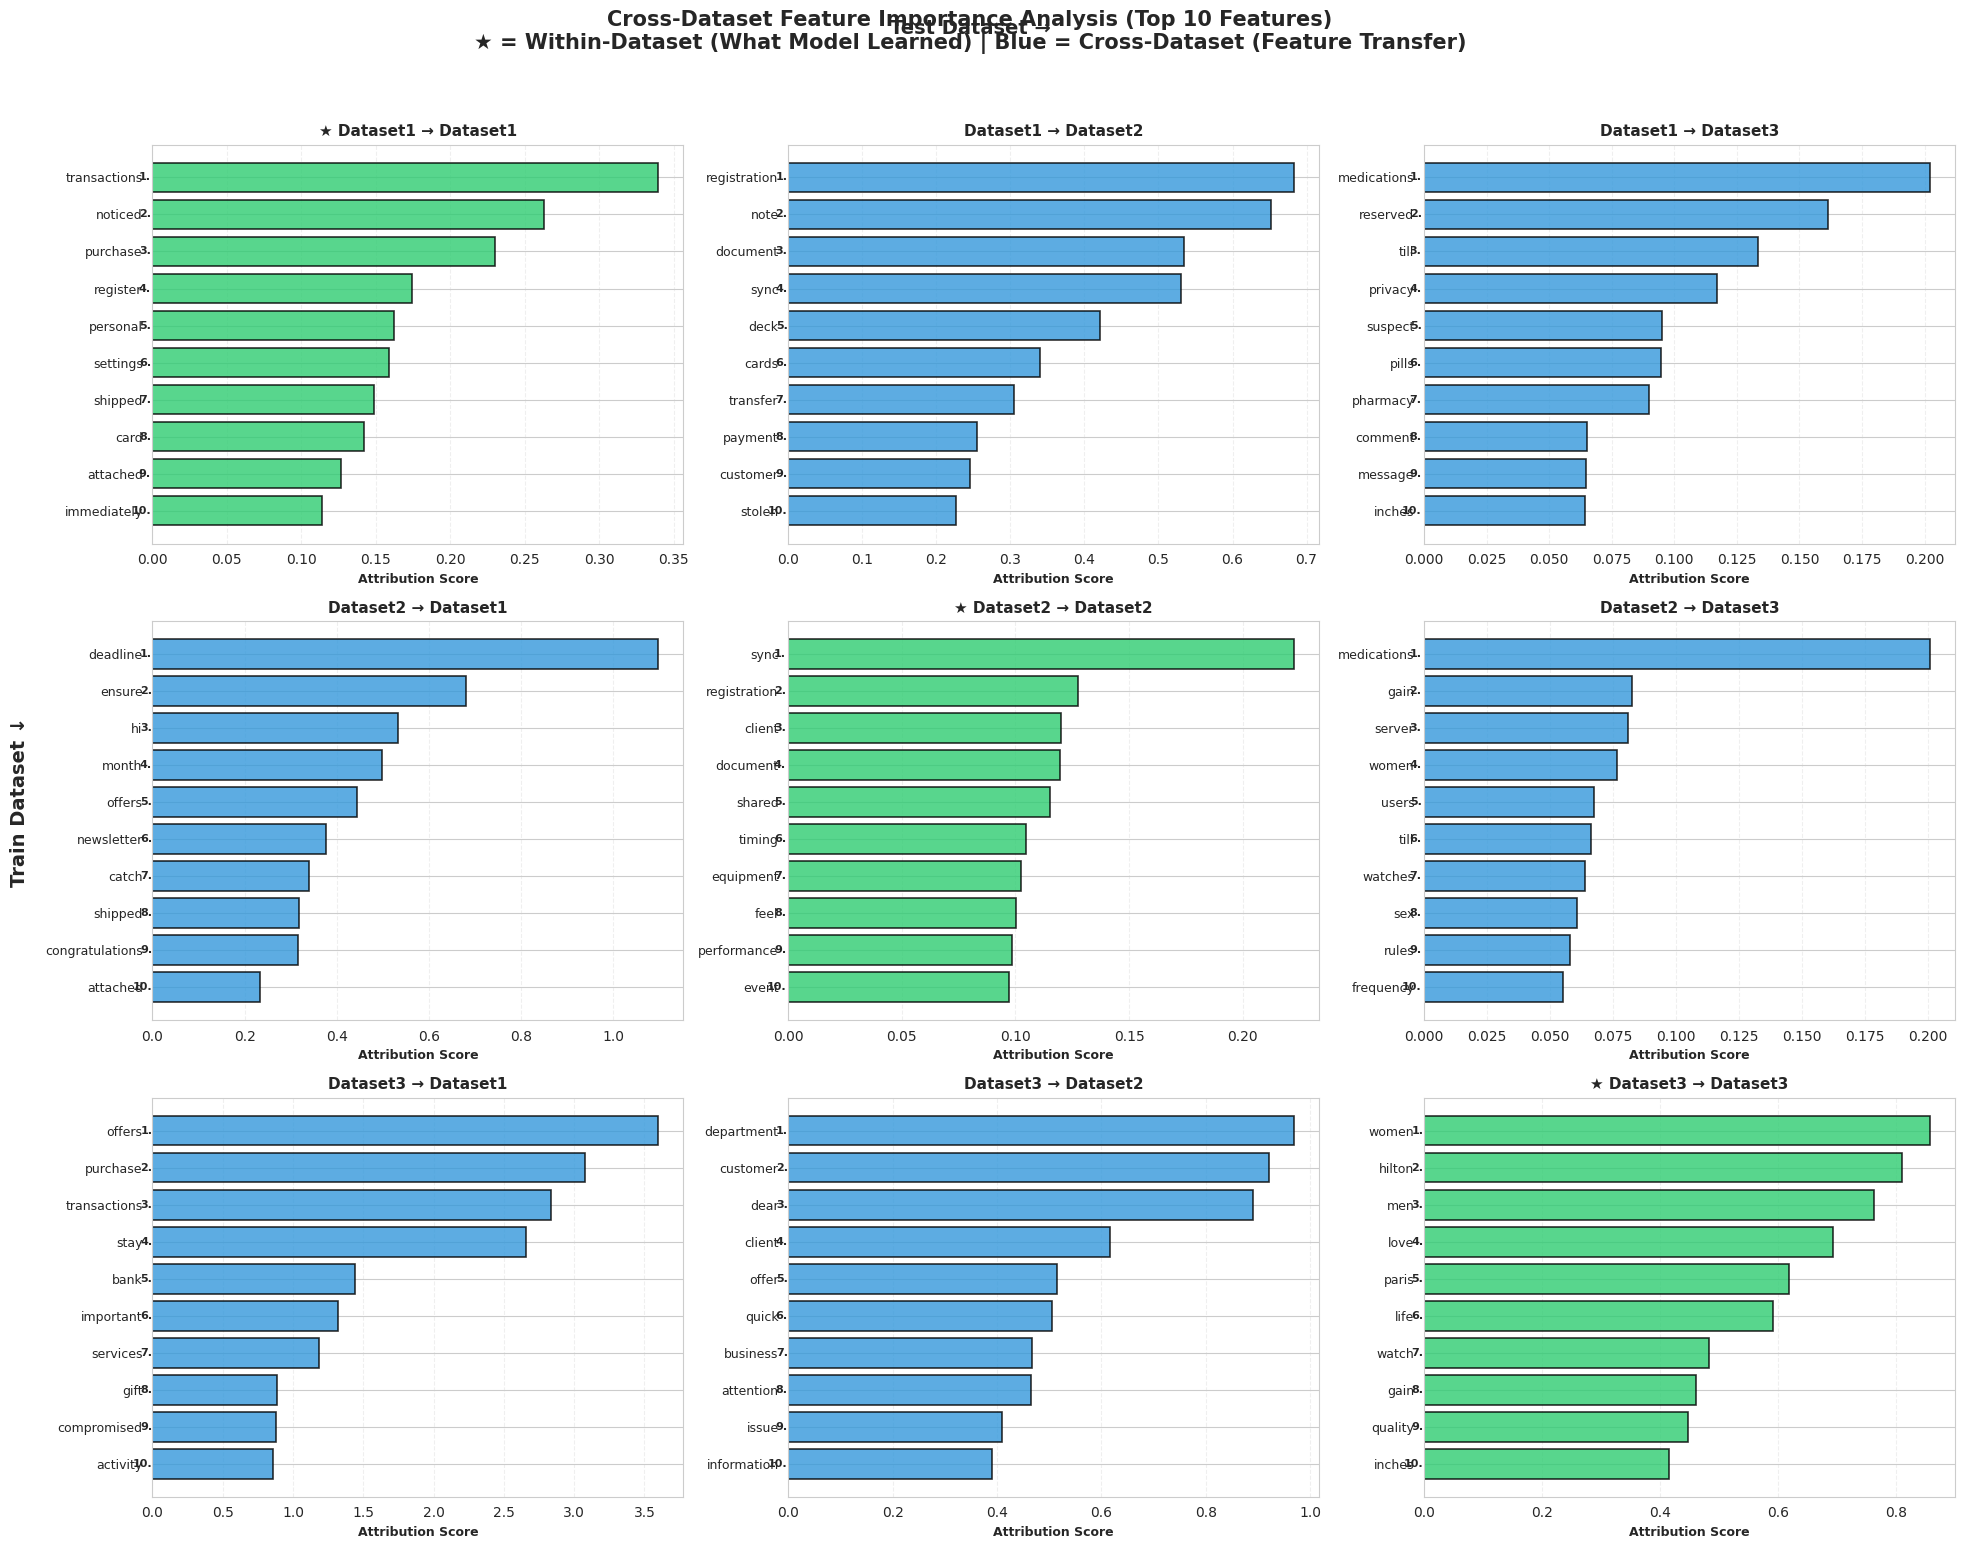

✓ 9-experiment grid visualization saved!


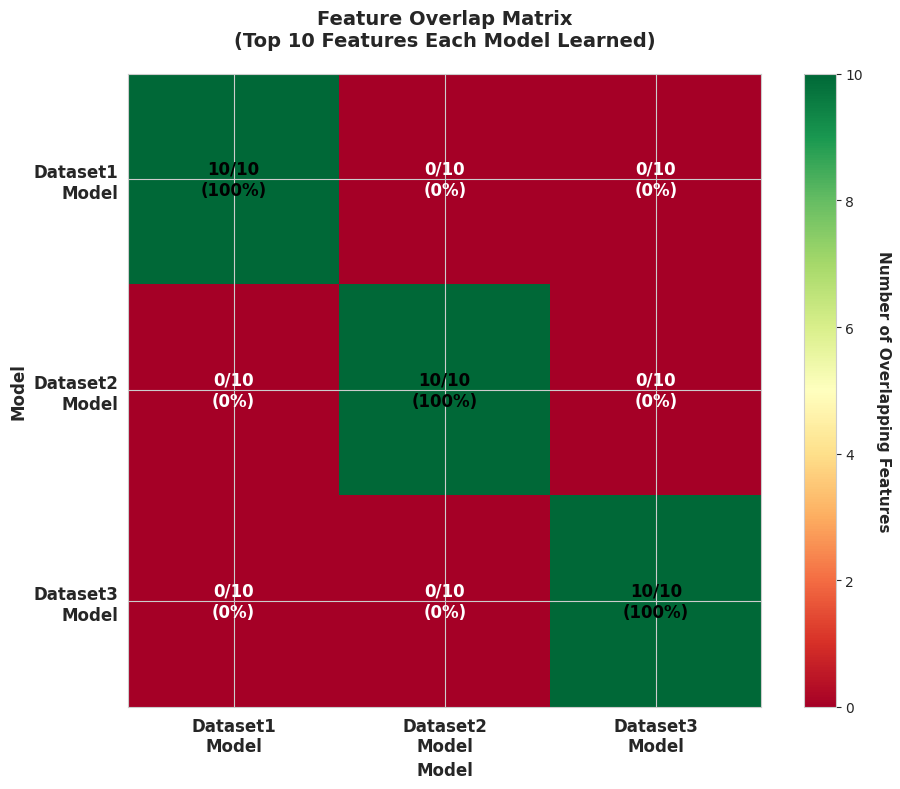

✓ Feature overlap heatmap saved!


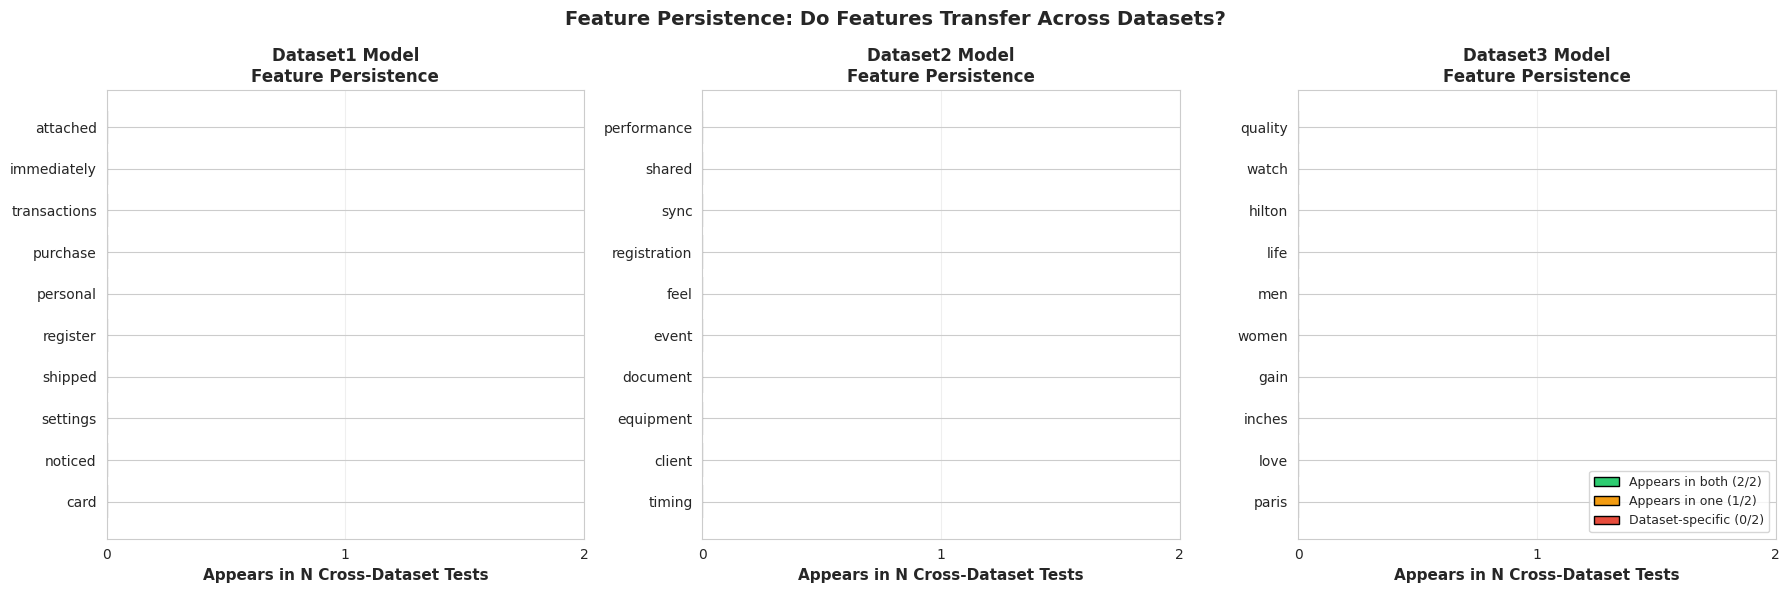

✓ Feature persistence visualization saved!


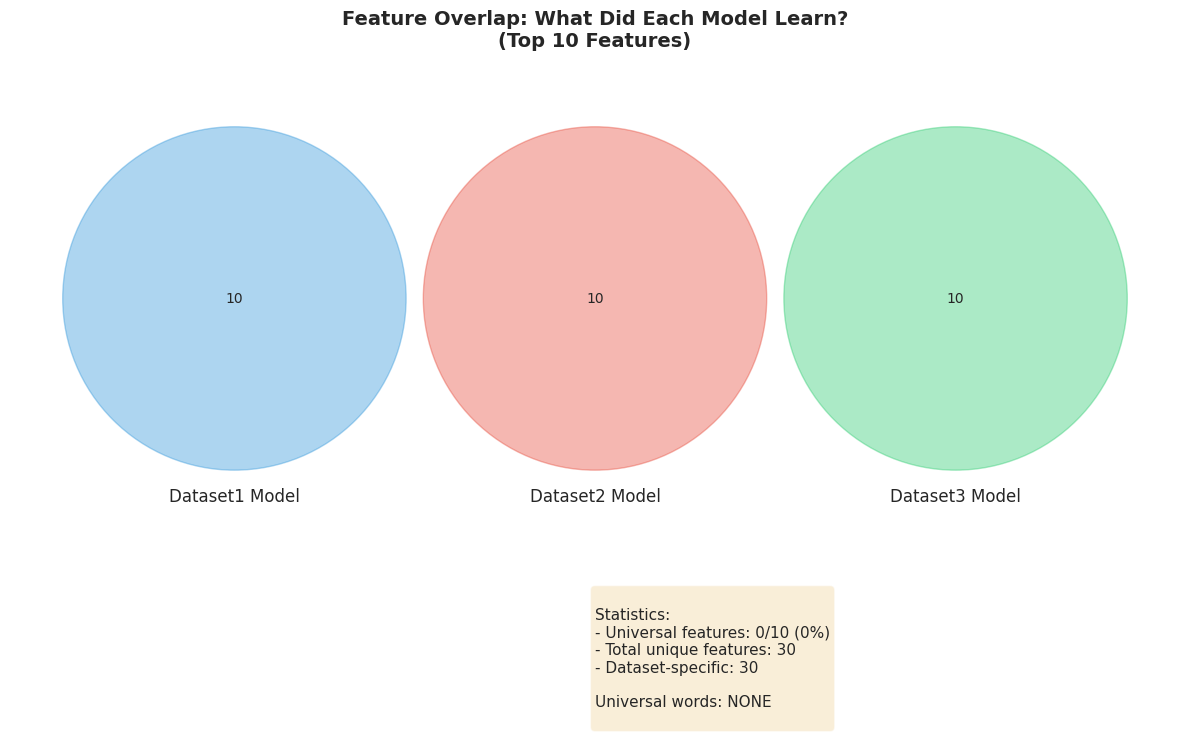

✓ Venn diagram saved!


LinAlgError: SVD did not converge in Linear Least Squares

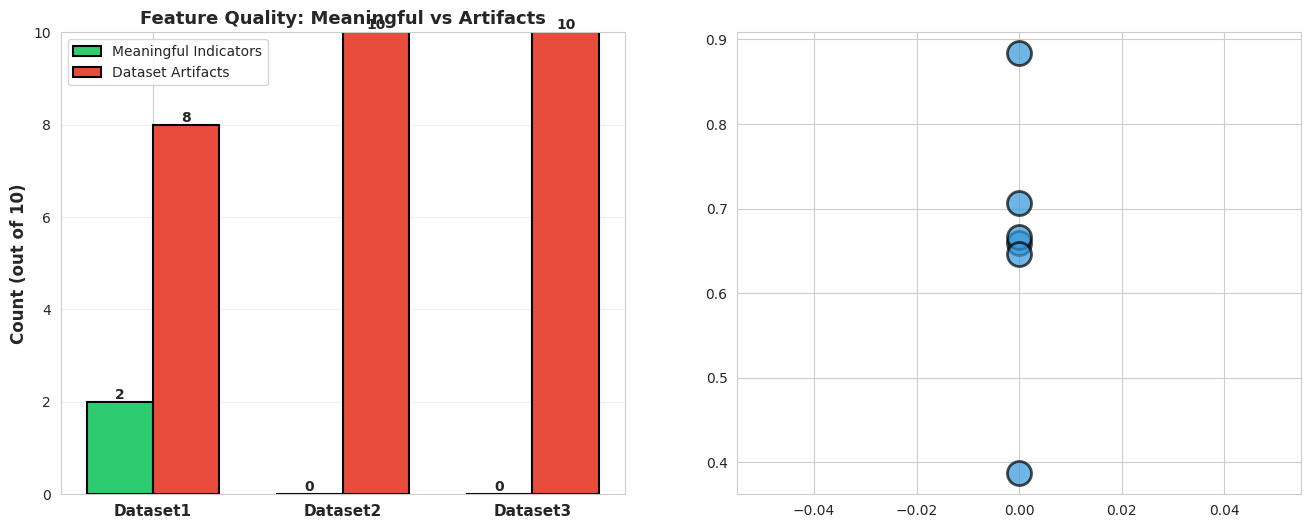

In [ ]:
# ============================================================================
# VISUALIZATION 1: TOP 10 FEATURES FOR ALL 9 EXPERIMENTS (3x3 Grid)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(20, 16))

train_datasets = ["Dataset1", "Dataset2", "Dataset3"]
test_datasets = ["Dataset1", "Dataset2", "Dataset3"]

for i, train_ds in enumerate(train_datasets):
    for j, test_ds in enumerate(test_datasets):
        experiment_key = f"{train_ds} → {test_ds}"
        result_df = all_feature_results[experiment_key]

        # Get top 10 words
        top_10 = result_df.head(10)

        ax = axes[i, j]

        # Create horizontal bar chart
        y_pos = np.arange(len(top_10))

        # Color: green if within-dataset, blue if cross-dataset
        if train_ds == test_ds:
            color = '#2ecc71'  # Green for diagonal (within-dataset)
            title_prefix = "★ "
        else:
            color = '#3498db'  # Blue for cross-dataset
            title_prefix = ""

        bars = ax.barh(y_pos, top_10['score'], color=color,
                       edgecolor='black', linewidth=1.2, alpha=0.8)

        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_10['token'], fontsize=9)
        ax.set_xlabel('Attribution Score', fontsize=9, fontweight='bold')
        ax.set_title(f'{title_prefix}{experiment_key}',
                     fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        # Add rank numbers
        for idx, (pos, score) in enumerate(zip(y_pos, top_10['score'])):
            ax.text(-0.001, pos, f'{idx+1}.',
                   ha='right', va='center', fontsize=8, fontweight='bold')

# Add row and column labels
fig.text(0.5, 0.98, 'Test Dataset →', ha='center', fontsize=14, fontweight='bold')
fig.text(0.02, 0.5, 'Train Dataset ↓', va='center', rotation='vertical',
         fontsize=14, fontweight='bold')

plt.suptitle('Cross-Dataset Feature Importance Analysis (Top 10 Features)\n' +
             '★ = Within-Dataset (What Model Learned) | Blue = Cross-Dataset (Feature Transfer)',
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
plt.savefig(f'{RESULTS_DIR}/feature_importance_9_experiments.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ 9-experiment grid visualization saved!")

# ============================================================================
# VISUALIZATION 2: FEATURE OVERLAP HEATMAP
# ============================================================================

# Calculate overlap matrix
overlap_matrix = np.zeros((3, 3))
feature_sets = {}

for i, train_ds in enumerate(train_datasets):
    for j, test_ds in enumerate(test_datasets):
        experiment_key = f"{train_ds} → {test_ds}"
        top_10 = set(all_feature_results[experiment_key].head(10)['token'].str.lower())
        feature_sets[experiment_key] = top_10

# Calculate pairwise overlaps
for i, train_ds1 in enumerate(train_datasets):
    for j, train_ds2 in enumerate(train_datasets):
        # Compare what each model learned (within-dataset features)
        key1 = f"{train_ds1} → {train_ds1}"
        key2 = f"{train_ds2} → {train_ds2}"

        overlap = len(feature_sets[key1] & feature_sets[key2])
        overlap_matrix[i, j] = overlap

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(overlap_matrix, cmap='RdYlGn', vmin=0, vmax=10)

# Set ticks and labels
ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(['Dataset1\nModel', 'Dataset2\nModel', 'Dataset3\nModel'],
                   fontsize=12, fontweight='bold')
ax.set_yticklabels(['Dataset1\nModel', 'Dataset2\nModel', 'Dataset3\nModel'],
                   fontsize=12, fontweight='bold')

# Add text annotations
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, f'{int(overlap_matrix[i, j])}/10\n({int(overlap_matrix[i, j]*10)}%)',
                      ha="center", va="center", color="black" if overlap_matrix[i, j] > 5 else "white",
                      fontsize=12, fontweight='bold')

ax.set_title('Feature Overlap Matrix\n(Top 10 Features Each Model Learned)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Number of Overlapping Features', rotation=270, labelpad=20,
               fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/feature_overlap_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature overlap heatmap saved!")

# ============================================================================
# VISUALIZATION 3: WITHIN vs CROSS-DATASET FEATURE COMPARISON
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, train_ds in enumerate(train_datasets):
    ax = axes[idx]

    # Get within-dataset features (what model learned)
    within_key = f"{train_ds} → {train_ds}"
    within_features = set(all_feature_results[within_key].head(10)['token'].str.lower())

    # Get cross-dataset features
    cross_keys = [f"{train_ds} → {test_ds}" for test_ds in test_datasets if test_ds != train_ds]

    # Calculate how many features persist in cross-dataset
    persistence_counts = {}
    for feat in within_features:
        count = sum(1 for key in cross_keys
                   if feat in set(all_feature_results[key].head(10)['token'].str.lower()))
        persistence_counts[feat] = count

    # Sort by persistence
    sorted_features = sorted(persistence_counts.items(), key=lambda x: x[1], reverse=True)

    features = [f[0] for f in sorted_features]
    counts = [f[1] for f in sorted_features]

    # Color by persistence
    colors = ['#2ecc71' if c == 2 else '#f39c12' if c == 1 else '#e74c3c' for c in counts]

    bars = ax.barh(range(len(features)), counts, color=colors,
                   edgecolor='black', linewidth=1.5)
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features, fontsize=10)
    ax.set_xlabel('Appears in N Cross-Dataset Tests', fontsize=11, fontweight='bold')
    ax.set_title(f'{train_ds} Model\nFeature Persistence', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.grid(axis='x', alpha=0.3)

    # Add legend
    if idx == 2:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2ecc71', edgecolor='black', label='Appears in both (2/2)'),
            Patch(facecolor='#f39c12', edgecolor='black', label='Appears in one (1/2)'),
            Patch(facecolor='#e74c3c', edgecolor='black', label='Dataset-specific (0/2)')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.suptitle('Feature Persistence: Do Features Transfer Across Datasets?',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/feature_persistence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature persistence visualization saved!")

# ============================================================================
# VISUALIZATION 4: VENN DIAGRAM (What Each Model Learned)
# ============================================================================

from matplotlib_venn import venn3

fig, ax = plt.subplots(figsize=(12, 10))

# Get top 10 features each model learned
model1_features = set(all_feature_results['Dataset1 → Dataset1'].head(10)['token'].str.lower())
model2_features = set(all_feature_results['Dataset2 → Dataset2'].head(10)['token'].str.lower())
model3_features = set(all_feature_results['Dataset3 → Dataset3'].head(10)['token'].str.lower())

venn = venn3([model1_features, model2_features, model3_features],
             ('Dataset1 Model', 'Dataset2 Model', 'Dataset3 Model'),
             ax=ax)

# Color the regions
if venn.get_patch_by_id('100'): venn.get_patch_by_id('100').set_color('#3498db')
if venn.get_patch_by_id('010'): venn.get_patch_by_id('010').set_color('#e74c3c')
if venn.get_patch_by_id('001'): venn.get_patch_by_id('001').set_color('#2ecc71')
if venn.get_patch_by_id('110'): venn.get_patch_by_id('110').set_color('#9b59b6')
if venn.get_patch_by_id('101'): venn.get_patch_by_id('101').set_color('#f39c12')
if venn.get_patch_by_id('011'): venn.get_patch_by_id('011').set_color('#1abc9c')
if venn.get_patch_by_id('111'): venn.get_patch_by_id('111').set_color('#34495e')

ax.set_title('Feature Overlap: What Did Each Model Learn?\n(Top 10 Features)',
             fontsize=14, fontweight='bold', pad=20)

# Add statistics text box
universal = model1_features & model2_features & model3_features
total_unique = len(model1_features | model2_features | model3_features)

stats_text = f'''
Statistics:
- Universal features: {len(universal)}/10 ({len(universal)/10*100:.0f}%)
- Total unique features: {total_unique}
- Dataset-specific: {total_unique - len(universal)}

Universal words: {sorted(universal) if universal else "NONE"}
'''

plt.text(0.5, -0.15, stats_text, transform=ax.transAxes,
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/feature_overlap_venn_diagram.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Venn diagram saved!")

# ============================================================================
# VISUALIZATION 5: SUMMARY STATISTICS BAR CHART
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Within-dataset feature diversity
within_unique_counts = []
within_labels = []

for train_ds in train_datasets:
    key = f"{train_ds} → {train_ds}"
    features = all_feature_results[key].head(10)['token'].str.lower()

    # Categorize as meaningful vs artifacts
    phishing_keywords = {
        'urgent', 'verify', 'account', 'suspended', 'click', 'here',
        'immediately', 'action', 'required', 'security', 'alert',
        'confirm', 'update', 'password', 'login', 'expire', 'limited',
        'congratulations', 'winner', 'prize', 'claim', 'free', 'gift',
        'bank', 'credit', 'card', 'payment', 'invoice', 'paypal',
        'dear', 'customer', 'user', 'attention', 'warning'
    }

    meaningful = sum(1 for f in features if f in phishing_keywords)
    artifacts = 10 - meaningful

    within_unique_counts.append([meaningful, artifacts])
    within_labels.append(train_ds)

within_array = np.array(within_unique_counts)

x = np.arange(len(within_labels))
width = 0.35

bars1 = ax1.bar(x - width/2, within_array[:, 0], width,
                label='Meaningful Indicators', color='#2ecc71',
                edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, within_array[:, 1], width,
                label='Dataset Artifacts', color='#e74c3c',
                edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Count (out of 10)', fontsize=12, fontweight='bold')
ax1.set_title('Feature Quality: Meaningful vs Artifacts', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(within_labels, fontsize=11, fontweight='bold')
ax1.legend(fontsize=10)
ax1.set_ylim(0, 10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right: Cross-dataset performance vs overlap
overlap_data = []
f1_data = []

cross_dataset_f1 = {
    'Dataset1 → Dataset2': 0.8837,
    'Dataset1 → Dataset3': 0.6593,
    'Dataset2 → Dataset1': 0.6664,
    'Dataset2 → Dataset3': 0.7067,
    'Dataset3 → Dataset1': 0.6465,
    'Dataset3 → Dataset2': 0.3871,
}

for key, f1 in cross_dataset_f1.items():
    train_ds, test_ds = key.split(' → ')

    train_features = set(all_feature_results[f"{train_ds} → {train_ds}"].head(10)['token'].str.lower())
    test_features = set(all_feature_results[f"{test_ds} → {test_ds}"].head(10)['token'].str.lower())

    overlap = len(train_features & test_features)
    overlap_data.append(overlap)
    f1_data.append(f1)

scatter = ax2.scatter(overlap_data, f1_data, s=300, c='#3498db',
                     edgecolors='black', linewidth=2, alpha=0.7)

# Add regression line
z = np.polyfit(overlap_data, f1_data, 1)
p = np.poly1d(z)
x_line = np.linspace(min(overlap_data), max(overlap_data), 100)
ax2.plot(x_line, p(x_line), "r--", linewidth=2,
         label=f'Trend (r={np.corrcoef(overlap_data, f1_data)[0,1]:.2f})')

ax2.set_xlabel('Feature Overlap (# of shared features)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cross-Dataset F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Correlation: Feature Overlap → Performance', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_ylim(0, 1.0)

plt.suptitle('Summary Analysis: Feature Quality and Performance Correlation',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/summary_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Summary analysis visualization saved!")

# ============================================================================
# PRINT SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)
print("\nGenerated 5 visualizations:")
print("  1. feature_importance_9_experiments.png - 3x3 grid of all experiments")
print("  2. feature_overlap_heatmap.png - Overlap between models")
print("  3. feature_persistence_analysis.png - Which features transfer")
print("  4. feature_overlap_venn_diagram.png - Universal vs unique features")
print("  5. summary_analysis.png - Feature quality + performance correlation")
print(f"\nAll saved to: {RESULTS_DIR}")
print("="*80)